<a href="https://colab.research.google.com/github/travisngt/ML_Breast_Cancer_Final_Project/blob/main/KNN_train_(19_11_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV Feature Data Shape: (63, 5)
       img_id  variance_equalized  variance_filtered  variance_psd   label
0  mdb015.png         6117.137152       1.102314e+14  7.282438e+44  benign
1  mdb010.png         6199.058482       8.917442e+13  2.825966e+44  benign
2  mdb002.png         6797.605528       1.078834e+14  2.895521e+44  benign
3  mdb005.png         7222.426432       1.551942e+14  1.263793e+45  benign
4  mdb013.png         6302.547778       8.994522e+13  1.935790e+44  benign
CSV Features Shape after dropping 'img_id' and 'label': (63, 3)
Number of Images: 63


<ipython-input-15-7c82c1052ffb>:53: RuntimeWarning: divide by zero encountered in scalar divide
  mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))


Filtered Image Shape: (1024, 1024, 2)
PSD Summary: 1.3968383417252651e+20
Extracted Feature Vector Size: 513
Filtered Image Shape: (1024, 1024, 2)
PSD Summary: 1.0707869566987488e+20
Extracted Feature Vector Size: 513
Filtered Image Shape: (1024, 1024, 2)
PSD Summary: 1.2847061324890345e+20
Extracted Feature Vector Size: 513
Filtered Image Shape: (1024, 1024, 2)
PSD Summary: 1.9520150209325842e+20
Extracted Feature Vector Size: 513
Filtered Image Shape: (1024, 1024, 2)
PSD Summary: 1.0667529318611888e+20
Extracted Feature Vector Size: 513
Filtered Image Shape: (1024, 1024, 2)
PSD Summary: 6.65613396772276e+19
Extracted Feature Vector Size: 513
Filtered Image Shape: (1024, 1024, 2)
PSD Summary: 1.7318678471728044e+20
Extracted Feature Vector Size: 513
Filtered Image Shape: (1024, 1024, 2)
PSD Summary: 1.338321354323799e+20
Extracted Feature Vector Size: 513
Filtered Image Shape: (1024, 1024, 2)
PSD Summary: 2.7653231112455756e+20
Extracted Feature Vector Size: 513
Filtered Image Shape: 

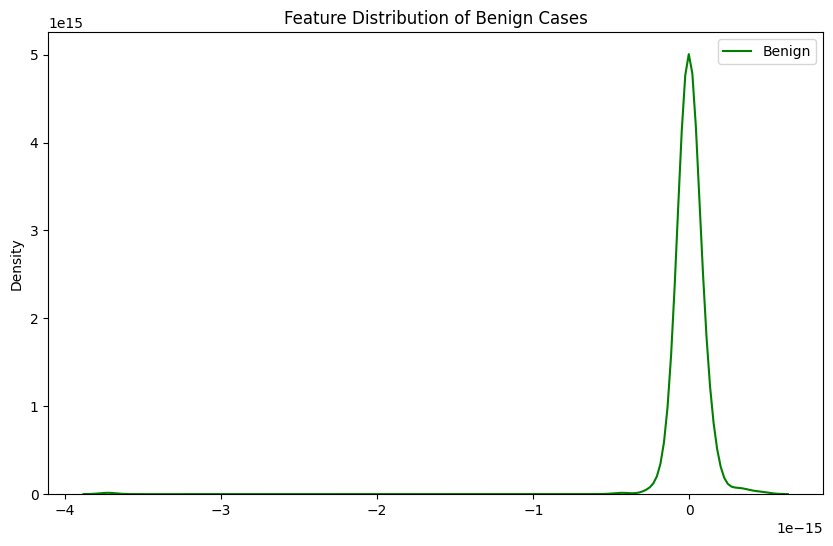

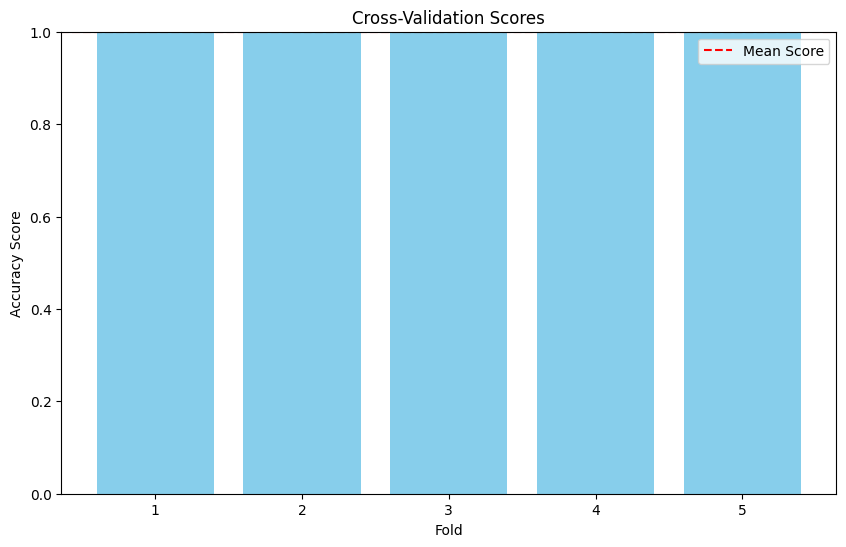

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


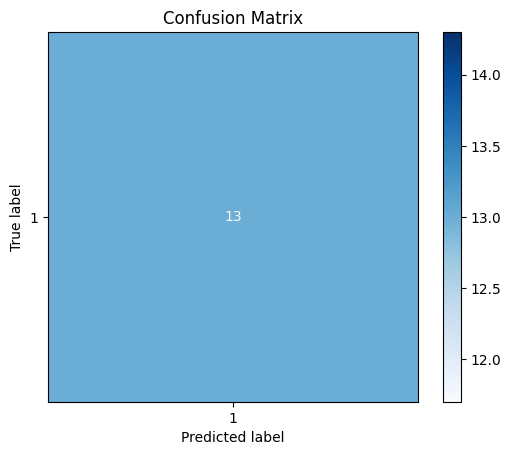

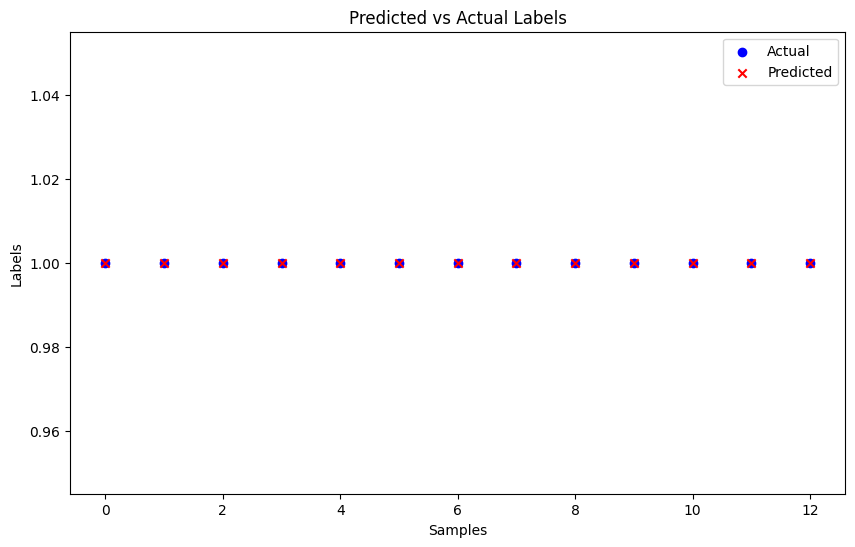

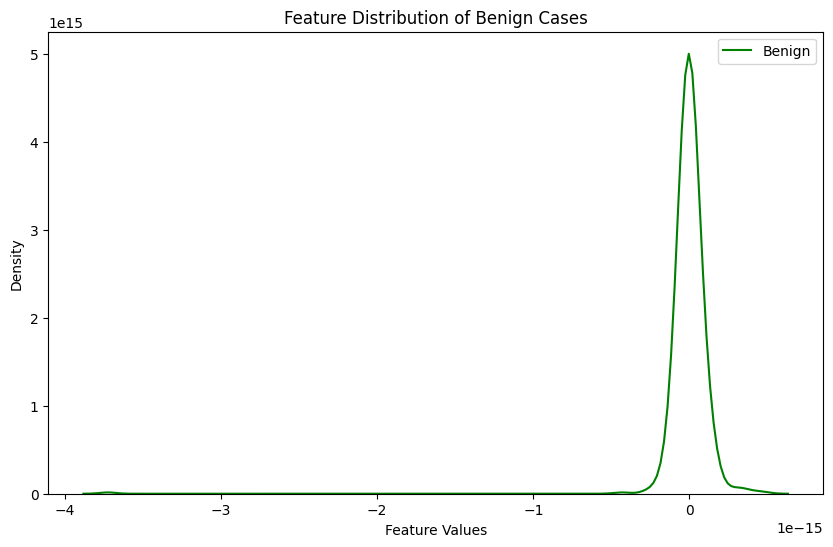

KNN Model Accuracy: 100.00%


In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set the folder path for images
folder_path = '/content/drive/My Drive/images_processed/benign_cases/'  # Update with the correct path

# Load the CSV data from the first script
csv_path = '/content/drive/My Drive/variance_data_train(benign)/benign_features.csv'  # Update path
csv_data = pd.read_csv(csv_path)

# Debugging Step: Check the loaded CSV data
print(f"CSV Feature Data Shape: {csv_data.shape}")
print(csv_data.head())  # Preview the CSV data

# Drop the 'img_id' and 'label' columns, as they are not needed for feature matrix
csv_features = csv_data.drop(columns=['img_id', 'label']).values
print(f"CSV Features Shape after dropping 'img_id' and 'label': {csv_features.shape}")  # Debugging Step

# Function to load an image
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or unable to load from {image_path}")
    return image

# Function for histogram equalization
def histogram_equalization(image):
    return cv2.equalizeHist(image)

# Butterworth highpass filter function
def butterworth_highpass_filter(image, cutoff_frequency, order):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            distance = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)
            mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))

    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)
    dft_shifted_filtered = dft_shifted * mask[..., np.newaxis]
    dft_filtered = np.fft.ifftshift(dft_shifted_filtered)
    filtered_image = cv2.idft(dft_filtered)

    # Debugging Step: Ensure filtered image shape is as expected
    print(f"Filtered Image Shape: {filtered_image.shape}")

    return cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Function to compute Power Spectral Density (PSD)
def compute_psd(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    psd = np.abs(fshift) ** 2
    # Debugging Step: Check PSD summary
    print(f"PSD Summary: {np.mean(psd)}")
    return psd

# Feature extraction from the image
def extract_features(image, x_center, y_center, radius):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    abnormality_region = image[y_center-radius:y_center+radius, x_center-radius:x_center+radius]
    abnormality_hist = cv2.calcHist([abnormality_region], [0], None, [256], [0, 256])
    abnormality_hist = cv2.normalize(abnormality_hist, abnormality_hist).flatten()

    psd = compute_psd(image)
    psd_summary = np.mean(psd)  # Summarize PSD

    # Debugging Step: Output size of feature vector
    features = np.hstack((hist, abnormality_hist, psd_summary))
    print(f"Extracted Feature Vector Size: {features.size}")

    return features

# Function to load and process dataset
def load_dataset(folder_path, coords):
    features = []
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]

    # Debugging Step: Ensure image paths are correctly loaded
    print(f"Number of Images: {len(image_paths)}")

    for i, image_path in enumerate(image_paths):
        image = load_image(image_path)
        equalized_image = histogram_equalization(image)
        filtered_image = butterworth_highpass_filter(equalized_image, cutoff_frequency=30, order=2)
        x_center, y_center, radius = coords[i]
        features.append(extract_features(filtered_image, x_center, y_center, radius))

    # Debugging Step: Ensure features are collected correctly
    print(f"Extracted Features for all Images Shape: {np.array(features).shape}")

    return np.array(features)

# Step 3: Define coordinates for images
image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
num_images = len(image_paths)
x_center, y_center, radius = 512, 512, 200  # Modify as necessary
coords = [(x_center, y_center, radius)] * num_images

# Load dataset and extract features from images
image_features = load_dataset(folder_path, coords)
print(f"Image Features Shape: {image_features.shape}")

# Step 5: Combine image features and CSV features
if image_features.size > 0 and len(csv_features) > 0:
    X = np.hstack((image_features[:len(csv_features)], csv_features))
    print(f"Final Dataset Shape: {X.shape}")
else:
    raise ValueError("Image features or CSV features are empty")

# Prepare labels (since all cases are benign, use 1s for labels)
y = np.ones(len(X))

# Step 6: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Scaled Feature Matrix Shape: {X_scaled.shape}")  # Debugging Step

# Step 7: Perform Cross-validation
k = 5  # Number of folds
knn = KNeighborsClassifier(n_neighbors=3)

# Perform cross-validation
scores = cross_val_score(knn, X_scaled, y, cv=k)
print(f"Cross-validation Scores: {scores}")  # Debugging Step
print(f"Mean Cross-validation Accuracy: {scores.mean():.2f}")

# Step 8: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Training Set Shape: {X_train.shape}, Testing Set Shape: {X_test.shape}")  # Debugging Step

# Train the KNN classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)
print(f"Predictions: {y_pred}")  # Debugging Step

# Visualize the feature distribution of benign cases
def visualize_features(features):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(np.mean(features, axis=0), label='Benign', color='green')
    plt.title("Feature Distribution of Benign Cases")
    plt.legend()
    plt.show()

# Visualize feature distribution
visualize_features(X_scaled)
# Visualize Cross-Validation Scores
def visualize_cross_val_scores(scores):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(scores) + 1), scores, color='skyblue')
    plt.xlabel("Fold")
    plt.ylabel("Accuracy Score")
    plt.title("Cross-Validation Scores")
    plt.xticks(range(1, len(scores) + 1))
    plt.ylim(0, 1)
    plt.axhline(y=scores.mean(), color='r', linestyle='--', label='Mean Score')
    plt.legend()
    plt.show()

# Visualize the Confusion Matrix
def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1])  # Since we have only benign cases
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Visualize Predicted vs. Actual Labels
def visualize_predicted_vs_actual(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_true)), y_true, color='blue', label='Actual', marker='o')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted', marker='x')
    plt.xlabel("Samples")
    plt.ylabel("Labels")
    plt.title("Predicted vs Actual Labels")
    plt.legend()
    plt.show()

# Visualize Feature Distribution of Benign Cases
def visualize_features(features):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(np.mean(features, axis=0), label='Benign', color='green')
    plt.title("Feature Distribution of Benign Cases")
    plt.xlabel("Feature Values")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Call the visualization functions
visualize_cross_val_scores(scores)
visualize_confusion_matrix(y_test, y_pred)
visualize_predicted_vs_actual(y_test, y_pred)
visualize_features(X_scaled)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy: {accuracy * 100:.2f}%")


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from google.colab import drive  # Import drive module

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set the correct folder path where the images are stored
folder_path = '/content/drive/My Drive/images_processed/benign_cases/'  # Update this with the correct path

# Load image as grayscale with error handling
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or unable to load from {image_path}")
    return image

# Feature 1: Histogram Equalization
def histogram_equalization(image):
    return cv2.equalizeHist(image)

# Feature 2: Butterworth Highpass Filter
def butterworth_highpass_filter(image, cutoff_frequency=30, order=2):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            distance = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)
            mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))

    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)
    dft_shifted_filtered = dft_shifted * mask[..., np.newaxis]
    dft_filtered = np.fft.ifftshift(dft_shifted_filtered)
    filtered_image = cv2.idft(dft_filtered)
    return cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Feature 3: Power Spectral Density (PSD) via FFT
def compute_psd(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    psd = np.abs(fshift) ** 2
    return psd

# Feature 4: Local Variance
def local_variance(image, kernel_size=3):
    mean = cv2.blur(image, (kernel_size, kernel_size))
    sq_mean = cv2.blur(image ** 2, (kernel_size, kernel_size))
    variance = sq_mean - mean ** 2
    return np.var(variance)

# Feature 5: Directional Variance
def directional_variance(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    variance_x = np.var(sobel_x)
    variance_y = np.var(sobel_y)
    return variance_x, variance_y

# Feature 6: Frequency-domain Variance
def frequency_domain_variance(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    return np.var(magnitude_spectrum)

# Feature 7: Noise Variance
def noise_variance(image):
    median = cv2.medianBlur(image, 3)
    noise = image - median
    return np.var(noise)

# Extract variance of features
def extract_variance_extended(image, cutoff_frequency=30, order=2):
    # Histogram Equalization
    equalized_image = histogram_equalization(image)

    # Butterworth Highpass Filter
    filtered_image = butterworth_highpass_filter(equalized_image, cutoff_frequency=cutoff_frequency, order=order)

    # PSD
    psd = compute_psd(filtered_image)

    # Calculate variance for original features
    variance_equalized = np.var(equalized_image)
    variance_filtered = np.var(filtered_image)
    variance_psd = np.var(psd)

    # Additional variances
    variance_local = local_variance(image)
    variance_freq = frequency_domain_variance(image)
    variance_noise = noise_variance(image)
    variance_x, variance_y = directional_variance(image)

    return (variance_equalized, variance_filtered, variance_psd,
            variance_local, variance_freq, variance_noise, variance_x, variance_y)

# Create feature table with extended variances
def create_feature_table_extended(image_paths, label):
    data = []
    for img_path in image_paths:
        print(f"Processing image: {img_path}")
        image_id = os.path.basename(img_path)

        # Load image with error handling
        try:
            image = load_image(img_path)
        except ValueError as e:
            print(f"Error loading image: {e}")
            continue

        # Extract variances
        variances = extract_variance_extended(image)
        (var_equalized, var_filtered, var_psd, var_local,
         var_freq, var_noise, var_x, var_y) = variances

        # Append data
        data.append({
            'img_id': image_id,
            'variance_equalized': var_equalized,
            'variance_filtered': var_filtered,
            'variance_psd': var_psd,
            'variance_local': var_local,
            'variance_frequency': var_freq,
            'variance_noise': var_noise,
            'variance_horizontal': var_x,
            'variance_vertical': var_y,
            'label': label
        })

    # Return DataFrame
    return pd.DataFrame(data)

# Example usage:
# Get image paths
image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]

# Check file existence
for img_path in image_paths:
    if not os.path.exists(img_path):
        print(f"File does not exist: {img_path}")
    else:
        print(f"File found: {img_path}")

# Assign label
label = 'benign'

# Check and create directory if it doesn't exist
output_dir = '/content/drive/My Drive/variance_data_train/'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Create feature table
feature_table_extended = create_feature_table_extended(image_paths, label)

# Save to CSV
output_csv = os.path.join(output_dir, 'benign_features_extended.csv')
feature_table_extended.to_csv(output_csv, index=False)

# Display the table
print(feature_table_extended)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found: /content/drive/My Drive/images_processed/benign_cases/mdb015.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb010.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb002.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb005.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb013.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb001.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb019.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb017.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb012.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb063.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb030.png
File found: /content/dri

<ipython-input-4-34e5e52b674d>:33: RuntimeWarning: divide by zero encountered in scalar divide
  mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))


Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb010.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb002.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb005.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb013.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb001.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb019.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb017.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb012.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb063.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb030.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb032.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb025.png
Proc

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from google.colab import drive  # Import drive module

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set the correct folder path where the images are stored
folder_path = '/content/drive/My Drive/images_processed/malignant_cases/'  # Update this with the correct path

# Load image as grayscale with error handling
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or unable to load from {image_path}")
    return image

# Feature 1: Histogram Equalization
def histogram_equalization(image):
    return cv2.equalizeHist(image)

# Feature 2: Butterworth Highpass Filter
def butterworth_highpass_filter(image, cutoff_frequency=30, order=2):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            distance = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)
            mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))

    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)
    dft_shifted_filtered = dft_shifted * mask[..., np.newaxis]
    dft_filtered = np.fft.ifftshift(dft_shifted_filtered)
    filtered_image = cv2.idft(dft_filtered)
    return cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Feature 3: Power Spectral Density (PSD) via FFT
def compute_psd(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    psd = np.abs(fshift) ** 2
    return psd

# Feature 4: Local Variance
def local_variance(image, kernel_size=3):
    mean = cv2.blur(image, (kernel_size, kernel_size))
    sq_mean = cv2.blur(image ** 2, (kernel_size, kernel_size))
    variance = sq_mean - mean ** 2
    return np.var(variance)

# Feature 5: Directional Variance
def directional_variance(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    variance_x = np.var(sobel_x)
    variance_y = np.var(sobel_y)
    return variance_x, variance_y

# Feature 6: Frequency-domain Variance
def frequency_domain_variance(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    return np.var(magnitude_spectrum)

# Feature 7: Noise Variance
def noise_variance(image):
    median = cv2.medianBlur(image, 3)
    noise = image - median
    return np.var(noise)

# Extract variance of features
def extract_variance_extended(image, cutoff_frequency=30, order=2):
    # Histogram Equalization
    equalized_image = histogram_equalization(image)

    # Butterworth Highpass Filter
    filtered_image = butterworth_highpass_filter(equalized_image, cutoff_frequency=cutoff_frequency, order=order)

    # PSD
    psd = compute_psd(filtered_image)

    # Calculate variance for original features
    variance_equalized = np.var(equalized_image)
    variance_filtered = np.var(filtered_image)
    variance_psd = np.var(psd)

    # Additional variances
    variance_local = local_variance(image)
    variance_freq = frequency_domain_variance(image)
    variance_noise = noise_variance(image)
    variance_x, variance_y = directional_variance(image)

    return (variance_equalized, variance_filtered, variance_psd,
            variance_local, variance_freq, variance_noise, variance_x, variance_y)

# Create feature table with extended variances
def create_feature_table_extended(image_paths, label):
    data = []
    for img_path in image_paths:
        print(f"Processing image: {img_path}")
        image_id = os.path.basename(img_path)

        # Load image with error handling
        try:
            image = load_image(img_path)
        except ValueError as e:
            print(f"Error loading image: {e}")
            continue

        # Extract variances
        variances = extract_variance_extended(image)
        (var_equalized, var_filtered, var_psd, var_local,
         var_freq, var_noise, var_x, var_y) = variances

        # Append data
        data.append({
            'img_id': image_id,
            'variance_equalized': var_equalized,
            'variance_filtered': var_filtered,
            'variance_psd': var_psd,
            'variance_local': var_local,
            'variance_frequency': var_freq,
            'variance_noise': var_noise,
            'variance_horizontal': var_x,
            'variance_vertical': var_y,
            'label': label
        })

    # Return DataFrame
    return pd.DataFrame(data)

# Example usage:
# Get image paths
image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]

# Check file existence
for img_path in image_paths:
    if not os.path.exists(img_path):
        print(f"File does not exist: {img_path}")
    else:
        print(f"File found: {img_path}")

# Assign label
label = 'malignant'

# Create feature table
feature_table_extended = create_feature_table_extended(image_paths, label)

# Save to CSV
output_csv = '/content/drive/My Drive/variance_data_train/malignant_features_extended.csv'
feature_table_extended.to_csv(output_csv, index=False)

# Display the table
print(feature_table_extended)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb028.png
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb023.png
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb058.png
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb111.png
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb072.png
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb110.png
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb075.png
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb102.png
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb090.png
File found: /content/drive/My Drive/images_processed/malignant_cases/mdb095.png
File found: /content/drive/My Drive/images_processed/malignant_cases/md

<ipython-input-3-1059bbef8297>:33: RuntimeWarning: divide by zero encountered in scalar divide
  mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))


Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb023.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb058.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb111.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb072.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb110.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb075.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb102.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb090.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb095.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb092.png
Processing image: /content/drive/My Drive/images_processed/malignant_cases/mdb105.png
Processing image: /content/drive/My Drive/images_proce

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from google.colab import drive  # Import drive module

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set the correct folder path where the images are stored
normal_folder_path = '/content/drive/My Drive/images_processed/normal_cases/'  # Update this with the correct path

# Feature Extraction Functions (Reusing from the original script)
# Load image as grayscale with error handling
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or unable to load from {image_path}")
    return image

# Feature 1: Histogram Equalization
def histogram_equalization(image):
    return cv2.equalizeHist(image)

# Feature 2: Butterworth Highpass Filter
def butterworth_highpass_filter(image, cutoff_frequency=30, order=2):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            distance = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)
            mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))

    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)
    dft_shifted_filtered = dft_shifted * mask[..., np.newaxis]
    dft_filtered = np.fft.ifftshift(dft_shifted_filtered)
    filtered_image = cv2.idft(dft_filtered)
    return cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Feature 3: Power Spectral Density (PSD) via FFT
def compute_psd(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    psd = np.abs(fshift) ** 2
    return psd

# Extract variance of features
def extract_variance(image, cutoff_frequency=30, order=2):
    # Histogram Equalization
    equalized_image = histogram_equalization(image)

    # Butterworth Highpass Filter
    filtered_image = butterworth_highpass_filter(equalized_image, cutoff_frequency=cutoff_frequency, order=order)

    # PSD
    psd = compute_psd(filtered_image)

    # Calculate variance for each feature
    variance_equalized = np.var(equalized_image)
    variance_filtered = np.var(filtered_image)
    variance_psd = np.var(psd)

    return variance_equalized, variance_filtered, variance_psd

# Create a feature table for images with error handling for missing images
def create_feature_table(image_paths, label):
    data = []
    for img_path in image_paths:
        print(f"Processing image: {img_path}")  # Check if paths are correct
        image_id = os.path.basename(img_path)  # Use the original filename as the image ID

        # Load image and handle cases where image loading fails
        try:
            image = load_image(img_path)
        except ValueError as e:
            print(f"Error loading image: {e}")
            continue  # Skip this image and move to the next one

        # Extract variances (from the three techniques)
        var_equalized, var_filtered, var_psd = extract_variance(image)

        # Append to the data list with consistent image IDs
        data.append({'img_id': image_id, 'variance_equalized': var_equalized,
                     'variance_filtered': var_filtered, 'variance_psd': var_psd, 'label': label})

    # Return a DataFrame with the variances and label
    return pd.DataFrame(data)

# Example usage:
# Path to the folder containing the normal images
normal_image_paths = [os.path.join(normal_folder_path, f) for f in os.listdir(normal_folder_path) if f.endswith('.png')]

# Check if files exist before processing
for img_path in normal_image_paths:
    if not os.path.exists(img_path):
        print(f"File does not exist: {img_path}")
    else:
        print(f"File found: {img_path}")

# These are normal cases
normal_label = 'normal'  # Adjust label accordingly

# Create the feature table with variances and labels for normal cases
normal_feature_table = create_feature_table(normal_image_paths, normal_label)

# Save the table to a CSV file (optional)
output_csv = '/content/drive/My Drive/variance_data_train/normal_features.csv'
normal_feature_table.to_csv(output_csv, index=False)

# Display the table
print(normal_feature_table)


Mounted at /content/drive
File found: /content/drive/My Drive/images_processed/normal_cases/mdb004.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb014.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb003.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb008.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb016.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb018.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb007.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb011.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb020.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb006.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb009.png
File found: /content/drive/My Drive/images_processed/normal_cases/mdb026.png
File found: /content/drive/My Drive/images_process

<ipython-input-1-c6c2221da29a>:34: RuntimeWarning: divide by zero encountered in scalar divide
  mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))


Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb014.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb003.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb008.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb016.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb018.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb007.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb011.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb020.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb006.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb009.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb026.png
Processing image: /content/drive/My Drive/images_processed/normal_cases/mdb043.png
Proc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found: /content/drive/My Drive/images_processed/benign_cases/mdb015.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb010.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb002.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb005.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb013.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb001.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb019.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb017.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb012.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb063.png
File found: /content/drive/My Drive/images_processed/benign_cases/mdb030.png
File found: /content/dri

<ipython-input-5-9b508fb7c914>:35: RuntimeWarning: divide by zero encountered in scalar divide
  mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))


Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb010.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb002.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb005.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb013.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb001.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb019.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb017.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb012.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb063.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb030.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb032.png
Processing image: /content/drive/My Drive/images_processed/benign_cases/mdb025.png
Proc

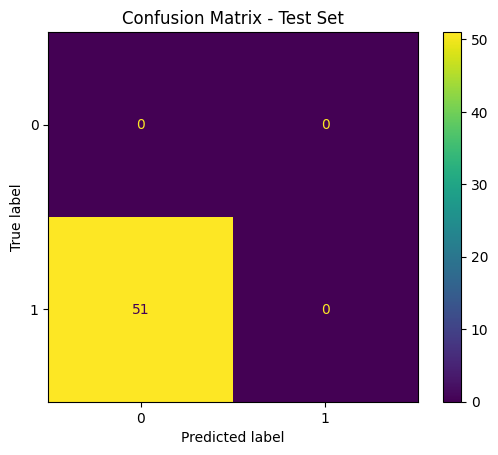

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from google.colab import drive

#mount

drive.mount('/content/drive')

# Load image as grayscale with error handling
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or unable to load from {image_path}")
    return image

# Feature 1: Histogram Equalization
def histogram_equalization(image):
    return cv2.equalizeHist(image)

# Feature 2: Butterworth Highpass Filter
def butterworth_highpass_filter(image, cutoff_frequency=30, order=2):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            distance = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)
            mask[u, v] = 1 / (1 + (cutoff_frequency / distance) ** (2 * order))

    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)
    dft_shifted_filtered = dft_shifted * mask[..., np.newaxis]
    dft_filtered = np.fft.ifftshift(dft_shifted_filtered)
    filtered_image = cv2.idft(dft_filtered)
    return cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

# Feature 3: Power Spectral Density (PSD) via FFT
def compute_psd(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    psd = np.abs(fshift) ** 2
    return psd

# Extract variance of features
def extract_variance(image, cutoff_frequency=30, order=2):
    # Histogram Equalization
    equalized_image = histogram_equalization(image)

    # Butterworth Highpass Filter
    filtered_image = butterworth_highpass_filter(equalized_image, cutoff_frequency=cutoff_frequency, order=order)

    # PSD
    psd = compute_psd(filtered_image)

    # Calculate variance for each feature
    variance_equalized = np.var(equalized_image)
    variance_filtered = np.var(filtered_image)
    variance_psd = np.var(psd)

    return variance_equalized, variance_filtered, variance_psd

# Create a feature table for images with error handling for missing images
def create_feature_table(image_paths, label):
    data = []
    for img_path in image_paths:
        print(f"Processing image: {img_path}")
        image_id = os.path.basename(img_path)

        # Load image and handle cases where image loading fails
        try:
            image = load_image(img_path)
        except ValueError as e:
            print(f"Error loading image: {e}")
            continue

        # Extract variances
        var_equalized, var_filtered, var_psd = extract_variance(image)

        # Append to the data list with consistent image IDs
        data.append({'img_id': image_id, 'variance_equalized': var_equalized,
                     'variance_filtered': var_filtered, 'variance_psd': var_psd, 'label': label})

    # Return a DataFrame with the variances and label
    return pd.DataFrame(data)

# Load and process the training and test data
def load_and_process_images(folder_path, label):
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]

    # Check if files exist
    for img_path in image_paths:
        if not os.path.exists(img_path):
            print(f"File does not exist: {img_path}")
        else:
            print(f"File found: {img_path}")

    # Create the feature table with variances and labels
    return create_feature_table(image_paths, label)

# Training dataset (benign cases)
train_folder_path = '/content/drive/My Drive/images_processed/benign_cases/'
train_data = load_and_process_images(train_folder_path, label='benign')

# Save the training and test feature tables to CSV (optional)
train_output_csv = '/content/drive/My Drive/variance_data_train(benign)/benign_features.csv'
train_data.to_csv(train_output_csv, index=False)

# Combine the datasets (optional if needed for specific classifiers)
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Display the combined dataset
print(f"Combined Dataset Shape: {combined_data.shape}")
print(combined_data.head())

# Prepare features and labels for training and testing
X_train = train_data.drop(columns=['img_id', 'label']).values
y_train = train_data['label'].values

X_test = test_data.drop(columns=['img_id', 'label']).values
y_test = test_data['label'].values

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = knn.predict(X_test_scaled)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy on Test Set: {accuracy * 100:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title('Confusion Matrix - Test Set')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Benign Data Shape: (63, 5)
Malignant Data Shape: (51, 5)
Cross-validation Scores: [0.34782609 0.47826087 0.34782609 0.39130435 0.36363636]
Mean Cross-validation Accuracy: 0.39
Training Set Shape: (91, 3), Testing Set Shape: (23, 3)
Predictions: [1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0.]

--- Logistic Regression ---
Best Logistic Regression Params: {'C': 10}
Logistic Regression Accuracy: 43.48%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.48      0.83      0.61        12

    accuracy                           0.43        23
   macro avg       0.24      0.42      0.30        23
weighted avg       0.25      0.43      0.32        23


--- Random Forest ---
Best Random Forest Params: {'max_depth': 20, 'n_estimators': 50}
Random Forest Accuracy: 47.83%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-3-544ccf38376e>:145: FutureWarning

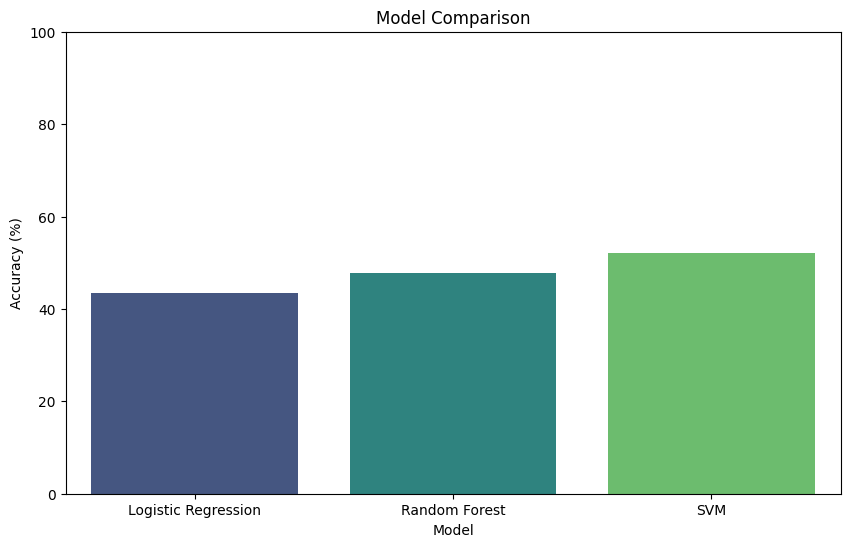

Final model saved to: /content/drive/My Drive/knn_final_model.pkl
Final KNN model trained on the complete dataset.
Prediction for sample data: [1.]


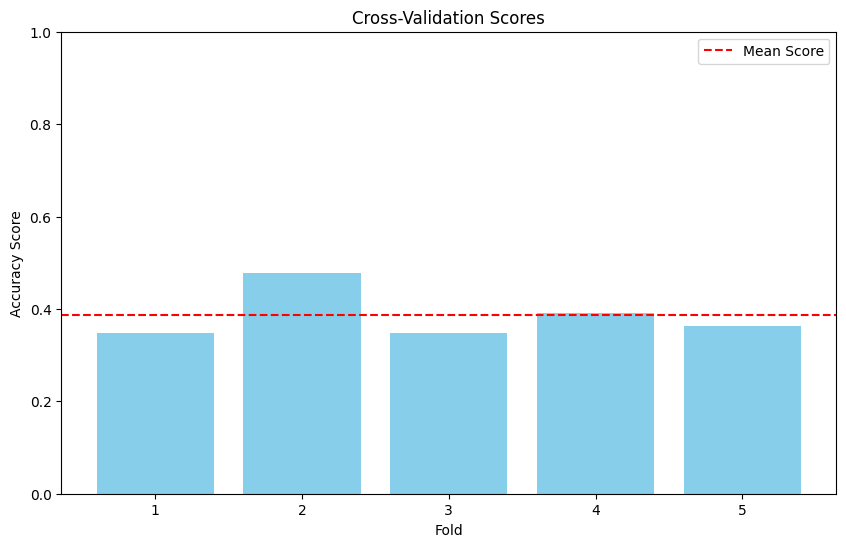

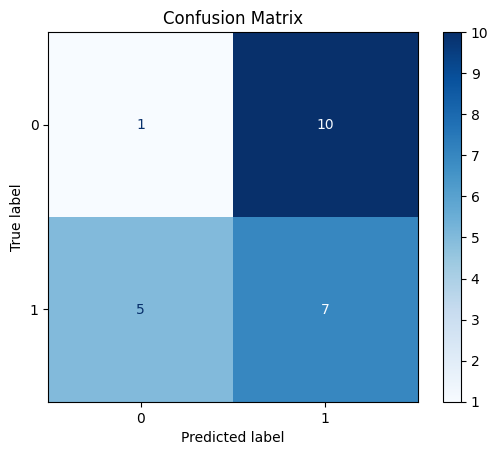

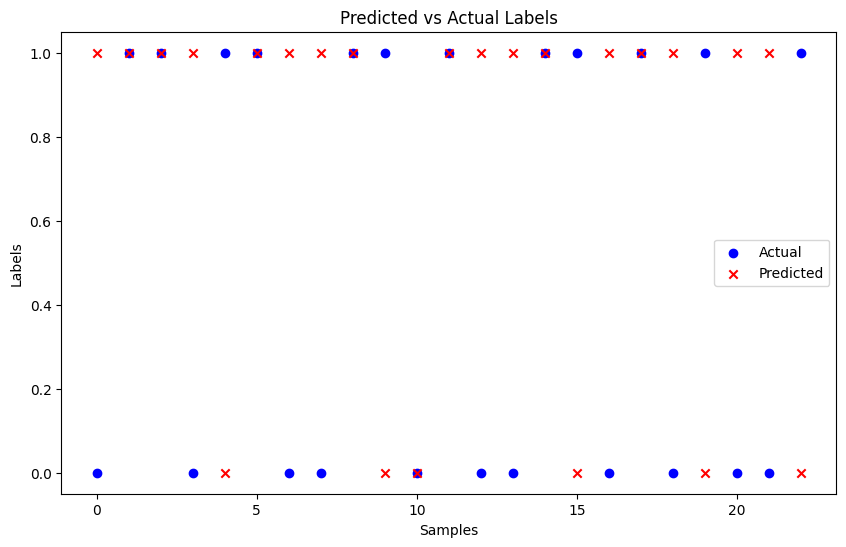

KNN Model Accuracy: 34.78%


In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Set paths for benign and malignant CSV data
benign_csv_path = '/content/drive/My Drive/variance_data_train(benign)/benign_features.csv'  # Benign features
malignant_csv_path = '/content/drive/My Drive/variance_data_train(malignant)/malignant_features.csv'  # Malignant features

# Load benign and malignant CSV data
benign_data = pd.read_csv(benign_csv_path)
malignant_data = pd.read_csv(malignant_csv_path)

# Debugging Step: Check the loaded CSV data
print(f"Benign Data Shape: {benign_data.shape}")
print(f"Malignant Data Shape: {malignant_data.shape}")

# Drop 'img_id' and keep only features for both benign and malignant data
benign_features = benign_data.drop(columns=['img_id', 'label']).values
malignant_features = malignant_data.drop(columns=['img_id', 'label']).values

# Labels: 1 for benign, 0 for malignant
benign_labels = np.ones(len(benign_features))
malignant_labels = np.zeros(len(malignant_features))

# Combine features and labels
X = np.vstack((benign_features, malignant_features))
y = np.hstack((benign_labels, malignant_labels))

# Step 3: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Perform Cross-validation
k = 5  # Number of folds
knn = KNeighborsClassifier(n_neighbors=3)

# Perform cross-validation
scores = cross_val_score(knn, X_scaled, y, cv=k)
print(f"Cross-validation Scores: {scores}")
print(f"Mean Cross-validation Accuracy: {scores.mean():.2f}")

# Step 5: Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Training Set Shape: {X_train.shape}, Testing Set Shape: {X_test.shape}")

# Train the KNN classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)
print(f"Predictions: {y_pred}")

# Step 6: Visualization

# Cross-Validation Scores
def visualize_cross_val_scores(scores):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(scores) + 1), scores, color='skyblue')
    plt.xlabel("Fold")
    plt.ylabel("Accuracy Score")
    plt.title("Cross-Validation Scores")
    plt.xticks(range(1, len(scores) + 1))
    plt.ylim(0, 1)
    plt.axhline(y=scores.mean(), color='r', linestyle='--', label='Mean Score')
    plt.legend()
    plt.show()
# Step 7: Combine train and test datasets
X_final = np.vstack((X_train, X_test))
y_final = np.hstack((y_train, y_test))

# Step 8: Train the KNN model with the complete dataset
knn_final = KNeighborsClassifier(n_neighbors=3)
knn_final.fit(X_final, y_final)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Step 9: Logistic Regression
print("\n--- Logistic Regression ---")
log_reg = LogisticRegression(max_iter=1000)
param_grid_lr = {'C': [0.1, 1, 10, 100]}  # Hyperparameter tuning
grid_search_lr = GridSearchCV(log_reg, param_grid_lr, cv=5)
grid_search_lr.fit(X_train, y_train)

# Best Logistic Regression Model
best_log_reg = grid_search_lr.best_estimator_
y_pred_lr = best_log_reg.predict(X_test)
print(f"Best Logistic Regression Params: {grid_search_lr.best_params_}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr) * 100:.2f}%")
print(classification_report(y_test, y_pred_lr))

# Step 10: Random Forest
print("\n--- Random Forest ---")
random_forest = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}
grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)

# Best Random Forest Model
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf) * 100:.2f}%")
print(classification_report(y_test, y_pred_rf))

# Step 11: Support Vector Machine (SVM)
print("\n--- Support Vector Machine (SVM) ---")
svm = SVC()
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)

# Best SVM Model
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
print(f"Best SVM Params: {grid_search_svm.best_params_}")
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm) * 100:.2f}%")
print(classification_report(y_test, y_pred_svm))

# Visualize and Compare Results
def visualize_model_comparisons(models, accuracies):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=accuracies, palette='viridis')
    plt.xlabel("Model")
    plt.ylabel("Accuracy (%)")
    plt.title("Model Comparison")
    plt.ylim(0, 100)
    plt.show()

# Collect Model Names and Accuracies
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [
    accuracy_score(y_test, y_pred_lr) * 100,
    accuracy_score(y_test, y_pred_rf) * 100,
    accuracy_score(y_test, y_pred_svm) * 100
]

# Visualize Model Accuracies
visualize_model_comparisons(models, accuracies)


# Save the model if needed
import pickle
model_path = '/content/drive/My Drive/knn_final_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(knn_final, file)
print(f"Final model saved to: {model_path}")

# Debugging Step: Print confirmation
print("Final KNN model trained on the complete dataset.")

# Example usage of the trained model
sample_data = X_scaled[:1]  # Using the first sample for prediction
prediction = knn_final.predict(sample_data)
print(f"Prediction for sample data: {prediction}")

# Optional: Load the model later for reuse
# with open(model_path, 'rb') as file:
#     knn_final_loaded = pickle.load(file)

# Confusion Matrix
def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # 0: Malignant, 1: Benign
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Predicted vs Actual Labels
def visualize_predicted_vs_actual(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_true)), y_true, color='blue', label='Actual', marker='o')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted', marker='x')
    plt.xlabel("Samples")
    plt.ylabel("Labels")
    plt.title("Predicted vs Actual Labels")
    plt.legend()
    plt.show()

# Visualize Cross-Validation Scores
visualize_cross_val_scores(scores)
visualize_confusion_matrix(y_test, y_pred)
visualize_predicted_vs_actual(y_test, y_pred)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



--- KNN ---
Best Params: {'n_neighbors': 10}
Accuracy: 52.17%
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        11
           1       0.53      0.75      0.62        12

    accuracy                           0.52        23
   macro avg       0.51      0.51      0.49        23
weighted avg       0.52      0.52      0.49        23


--- Logistic Regression ---
Best Params: {'C': 0.1}
Accuracy: 65.22%
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.61      0.92      0.73        12

    accuracy                           0.65        23
   macro avg       0.71      0.64      0.62        23
weighted avg       0.70      0.65      0.62        23


--- Random Forest ---
Best Params: {'max_depth': 20, 'n_estimators': 100}
Accuracy: 47.83%
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1

<ipython-input-5-6cfb652640dd>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


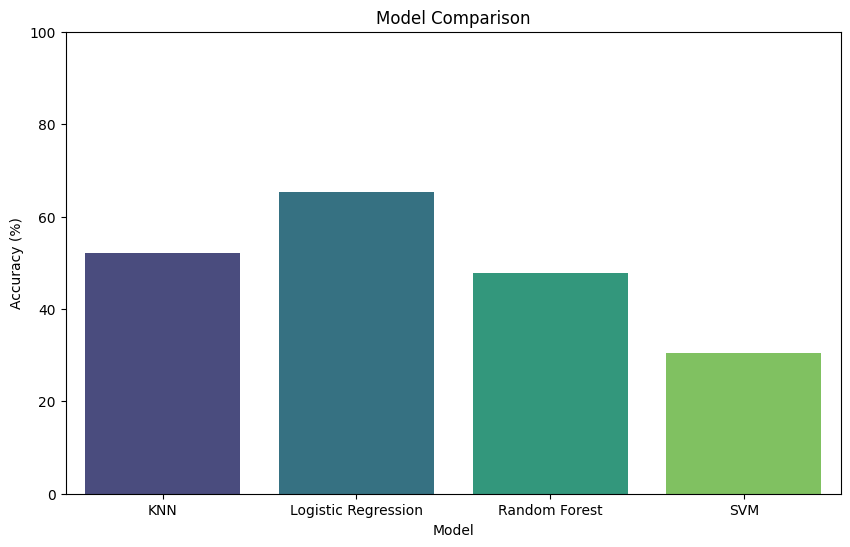

In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Function to preprocess images
def preprocess_image(image_path):
    # Read the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize to 512x512
    resized_image = cv2.resize(image, (512, 512))
    # Crop the central region (remove rìa)
    crop_size = 100  # Crop 100 pixels from each edge
    cropped_image = resized_image[crop_size:-crop_size, crop_size:-crop_size]
    return cropped_image.flatten()  # Flatten to a 1D array

# Load dataset function
def load_dataset(folder_path, label):
    features = []
    labels = []
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Folder does not exist: {folder_path}")
    for file in os.listdir(folder_path):
        if file.endswith('.png') or file.endswith('.jpg'):
            file_path = os.path.join(folder_path, file)
            processed_image = preprocess_image(file_path)
            features.append(processed_image)
            labels.append(label)
    return np.array(features), np.array(labels)

# Define paths for benign and malignant datasets
benign_path = '/content/drive/My Drive/images_processed/benign_cases/'
malignant_path = '/content/drive/My Drive/images_processed/malignant_cases/'

# Preprocess and load datasets
X_benign, y_benign = load_dataset(benign_path, 1)  # Label 1 for benign
X_malignant, y_malignant = load_dataset(malignant_path, 0)  # Label 0 for malignant

# Combine features and labels
X = np.vstack((X_benign, X_malignant))
y = np.hstack((y_benign, y_malignant))

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Function to evaluate models
def evaluate_model(model, param_grid, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"\n--- {model_name} ---")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    return best_model

# Step 4: Define and evaluate models
# KNN
knn_params = {'n_neighbors': range(1, 11)}
best_knn = evaluate_model(KNeighborsClassifier(), knn_params, "KNN")

# Logistic Regression
log_reg_params = {'C': [0.1, 1, 10, 100]}
best_log_reg = evaluate_model(LogisticRegression(max_iter=1000), log_reg_params, "Logistic Regression")

# Random Forest
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
best_rf = evaluate_model(RandomForestClassifier(), rf_params, "Random Forest")

# SVM
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
best_svm = evaluate_model(SVC(), svm_params, "SVM")

# Step 5: Compare Model Performance
models = ['KNN', 'Logistic Regression', 'Random Forest', 'SVM']
accuracies = [
    accuracy_score(y_test, best_knn.predict(X_test)) * 100,
    accuracy_score(y_test, best_log_reg.predict(X_test)) * 100,
    accuracy_score(y_test, best_rf.predict(X_test)) * 100,
    accuracy_score(y_test, best_svm.predict(X_test)) * 100,
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Comparison")
plt.ylim(0, 100)
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Given raw text data (replace with the actual full data for real use)
raw_data = """mdb001 G CIRC B 535 425 197
mdb002 G CIRC B 522 280 69
mdb003 D NORM
mdb004 D NORM
mdb005 F CIRC B 477 133 30
mdb005 F CIRC B 500 168 26
mdb006 F NORM
mdb007 G NORM
mdb008 G NORM
mdb009 F NORM
mdb010 F CIRC B 525 425 33
mdb011 F NORM
mdb012 F CIRC B 471 458 40
mdb013 G MISC B 667 365 31
mdb014 G NORM
mdb015 G CIRC B 595 864 68
mdb016 G NORM
mdb017 G CIRC B 547 573 48
mdb018 G NORM
mdb019 G CIRC B 653 477 49
mdb020 G NORM
mdb021 G CIRC B 493 125 49
mdb022 G NORM
mdb023 G CIRC M 538 681 29
mdb024 G NORM
mdb025 F CIRC B 674 443 79
mdb026 F NORM
mdb027 F NORM
mdb028 F CIRC M 338 314 56
mdb029 G NORM
mdb030 G MISC B 322 676 43
mdb031 G NORM
mdb032 G MISC B 388 742 66
mdb033 D NORM
mdb034 D NORM
mdb035 D NORM
mdb036 D NORM
mdb037 D NORM
mdb038 D NORM
mdb039 D NORM
mdb040 D NORM
mdb041 G NORM
mdb042 G NORM
mdb043 G NORM
mdb044 G NORM
mdb045 G NORM
mdb046 G NORM
mdb047 G NORM
mdb048 G NORM
mdb049 G NORM
mdb050 G NORM
mdb051 G NORM
mdb052 G NORM
mdb053 D NORM
mdb054 D NORM
mdb055 G NORM
mdb056 G NORM
mdb057 D NORM
mdb058 D MISC M 318 359 27
mdb059 F CIRC B
mdb060 F NORM
mdb061 D NORM
mdb062 D NORM
mdb063 D MISC B 546 463 33
mdb064 D NORM
mdb065 D NORM
mdb066 D NORM
mdb067 D NORM
mdb068 D NORM
mdb069 F CIRC B 462 406 44
mdb070 F NORM
mdb071 G NORM
mdb072 G ASYM M 266 517 28
mdb073 G NORM
mdb074 G NORM
mdb075 F ASYM M 468 717 23
mdb076 F NORM
mdb077 F NORM
mdb078 F NORM
mdb079 F NORM
mdb080 F CIRC B 432 149 20
mdb081 G ASYM B 492 473 131
mdb082 G NORM
mdb083 G ASYM B 544 194 38
mdb084 G NORM
mdb085 G NORM
mdb086 G NORM
mdb087 F NORM
mdb088 F NORM
mdb089 G NORM
mdb090 G ASYM M 510 547 49
mdb091 F CIRC B 680 494 20
mdb092 F ASYM M 423 662 43
mdb093 G NORM
mdb094 G NORM
mdb095 F ASYM M 466 517 29
mdb096 F NORM
mdb097 F ASYM B 612 297 34
mdb098 F NORM
mdb099 D ASYM B 714 340 23
mdb100 D NORM
mdb101 D NORM
mdb102 D ASYM M 415 460 38
mdb103 D NORM
mdb104 D ASYM B 357 365 50
mdb105 D ASYM M 516 279 98
mdb106 D NORM
mdb107 D ASYM B 600 621 111
mdb108 D NORM
mdb109 D NORM
mdb110 D ASYM M 190 427 51
mdb111 D ASYM M 505 575 107
mdb112 D NORM
mdb113 G NORM
mdb114 G NORM
mdb115 G ARCH M 461 532 117
mdb116 G NORM
mdb117 G ARCH M 480 576 84
mdb118 G NORM
mdb119 G NORM
mdb120 G ARCH M 423 262 79
mdb121 G ARCH B 492 434 87
mdb122 G NORM
mdb123 G NORM
mdb124 G ARCH M 366 620 33
mdb125 D ARCH M 700 552 60
mdb126 D ARCH B 191 549 23
mdb127 G ARCH B 523 551 48
mdb128 G NORM
mdb129 D NORM
mdb130 D ARCH M 220 552 28
mdb131 F NORM
mdb132 F CIRC B 252 788 52
mdb132 F CIRC B 335 766 18
mdb133 F NORM
mdb134 F MISC M 469 728 49
mdb135 F NORM
mdb136 F NORM
mdb137 D NORM
mdb138 D NORM
mdb139 F NORM
mdb140 F NORM
mdb141 F CIRC M 470 759 29
mdb142 F CIRC B 347 636 26
mdb143 F NORM
mdb144 F MISC B 233 994 29
mdb144 F MISC M 313 540 27
mdb145 D SPIC B 669 543 49
mdb146 D NORM
mdb147 F NORM
mdb148 F SPIC M 326 607 174
mdb149 F NORM
mdb150 F ARCH B 351 661 62
mdb151 F NORM
mdb152 F ARCH B 675 486 48
mdb153 F NORM
mdb154 F NORM
mdb155 F ARCH M 448 480 95
mdb156 F NORM
mdb157 F NORM
mdb158 F ARCH M 540 565 88
mdb159 F NORM
mdb160 F ARCH B 536 519 61
mdb161 D NORM
mdb162 D NORM
mdb163 D ARCH B 391 365 50
mdb164 D NORM
mdb165 D ARCH B 537 490 42
mdb166 D NORM
mdb167 F ARCH B 574 657 35
mdb168 F NORM
mdb169 D NORM
mdb170 D ARCH M 489 480 82
mdb171 D ARCH M 462 627 62
mdb172 D NORM
mdb173 F NORM
mdb174 F NORM
mdb175 G SPIC B 592 670 33
mdb176 G NORM
mdb177 G NORM
mdb178 G SPIC M 492 600 70
mdb179 D SPIC M 600 514 67
mdb180 D NORM
mdb181 G SPIC M 519 362 54
mdb182 G NORM
mdb183 F NORM
mdb184 F SPIC M 352 624 114
mdb185 G NORM
mdb186 G SPIC M 403 524 47
mdb187 G NORM
mdb188 G SPIC B 406 617 61
mdb189 G NORM
mdb190 G SPIC B 512 621 31
mdb191 G SPIC B 594 516 41
mdb192 G NORM
mdb193 D SPIC B 399 563 132
mdb194 D NORM
mdb195 F SPIC B 725 129 26
mdb196 F NORM
mdb197 D NORM
mdb198 D SPIC B 568 612 93
mdb199 D SPIC B 641 177 31
mdb200 D NORM
mdb201 D NORM
mdb202 D SPIC M 557 772 37
mdb203 F NORM
mdb204 F SPIC B 336 399 21
mdb205 F NORM
mdb206 F SPIC M 368 200 17
mdb207 D SPIC B 571 564 19
mdb208 D NORM
mdb209 G CALC M 647 503 87
mdb210 G NORM
mdb211 G CALC M 680 327 13
mdb212 G CALC B 687 882 3
mdb213 G CALC M 547 520 45
mdb214 G CALC B 582 916 11
mdb215 D NORM
mdb216 D CALC M *NOTE 3*
mdb217 G NORM
mdb218 G CALC B 519 629 8
mdb219 G CALC B 546 756 29
mdb220 G NORM
mdb221 D NORM
mdb222 D CALC B 398 427 17
mdb223 D CALC B 523 482 29
mdb223 D CALC B 591 529 6
mdb224 D NORM
mdb225 D NORM
mdb226 D CALC B 287 610 7
mdb226 D CALC B 329 550 25
mdb226 D CALC B 531 721 8
mdb227 G CALC B 504 467 9
mdb228 G NORM
mdb229 F NORM
mdb230 F NORM
mdb231 F CALC M 603 538 44
mdb232 F NORM
mdb233 G CALC M *NOTE 3*
mdb234 G NORM
mdb235 D NORM
mdb236 D CALC B 276 824 14
mdb237 F NORM
mdb238 F CALC M 522 553 17
mdb239 D CALC M 645 755 40
mdb239 D CALC M 567 808 25
mdb240 D CALC B 643 614 23
mdb241 D CALC M 453 678 38
mdb242 D NORM
mdb243 D NORM
mdb244 D CIRC B 466 567 52
mdb245 F CALC M *NOTE 3*
mdb246 F NORM
mdb247 F NORM
mdb248 F CALC B 378 601 10
mdb249 D CALC M 544 508 48
mdb249 D CALC M 575 639 64
mdb250 D NORM
mdb251 F NORM
mdb252 F CALC B 439 367 23
mdb253 D CALC M 733 564 28
mdb254 D NORM
mdb255 F NORM
mdb256 F CALC M 400 484 37
mdb257 D NORM
mdb258 D NORM
mdb259 D NORM
mdb260 D NORM
mdb261 D NORM
mdb262 D NORM
mdb263 G NORM
mdb264 G MISC M 596 431 36
mdb265 G MISC M 593 498 60
mdb266 G NORM
mdb267 F MISC M 793 481 56
mdb268 F NORM
mdb269 G NORM
mdb270 G CIRC M 356 945 72
mdb271 F MISC M 784 270 68
mdb272 F NORM
mdb273 F NORM
mdb274 F MISC M 127 505 123
mdb275 G NORM
mdb276 G NORM
mdb277 G NORM
mdb278 G NORM
mdb279 G NORM
mdb280 G NORM
mdb281 D NORM
mdb282 D NORM
mdb283 D NORM
mdb284 D NORM
mdb285 D NORM
mdb286 D NORM
mdb287 D NORM
mdb288 D NORM
mdb289 D NORM
mdb290 D CIRC B 337 353 45
mdb291 G NORM
mdb292 G NORM
mdb293 F NORM
mdb294 F NORM
mdb295 D NORM
mdb296 D NORM
mdb297 F NORM
mdb298 F NORM
mdb299 F NORM
mdb300 F NORM
mdb301 F NORM
mdb302 F NORM
mdb303 F NORM
mdb304 F NORM
mdb305 F NORM
mdb306 F NORM
mdb307 F NORM
mdb308 F NORM
mdb309 F NORM
mdb310 F NORM
mdb311 F NORM
mdb312 F MISC B 240 263 20
mdb313 F NORM
mdb314 F MISC B 518 191 39
mdb315 D CIRC B 516 447 93
mdb316 D NORM
mdb317 D NORM
mdb318 D NORM
mdb319 D NORM
mdb320 D NORM
mdb321 D NORM
mdb322 D NORM
"""

# Step 1: Process the raw data into a structured format
data = []

# Split raw data into lines
lines = raw_data.split('\n')

for line in lines:
    if line.strip() == "":
        continue  # Skip empty lines
    parts = line.split()

    # Extract values with fallback for missing information
    image_id = parts[0]
    density = parts[1]
    lesion_type = parts[2]

    if lesion_type == "NORM":
        label = 0  # Normal case
        x, y, radius = np.nan, np.nan, np.nan  # No abnormality present
    else:
        # Extract benign/malignant label and x, y, radius if available
        benign_malignant = parts[3]
        label = 1 if benign_malignant == "B" else 2  # 1 for Benign, 2 for Malignant

        if len(parts) >= 7:
            x, y, radius = int(parts[4]), int(parts[5]), int(parts[6])
        else:
            x, y, radius = np.nan, np.nan, np.nan  # Missing data

    # Append the data in structured format
    data.append([image_id, density, lesion_type, label, x, y, radius])

# Create a DataFrame from the structured data
columns = ['Image_ID', 'Density', 'Lesion_Type', 'Label', 'X_Center', 'Y_Center', 'Radius']
df = pd.DataFrame(data, columns=columns)

# Step 2: Handle missing values
# Replace missing values (NaN) with the mean of each respective column
df['X_Center'] = df['X_Center'].fillna(df['X_Center'].mean())
df['Y_Center'] = df['Y_Center'].fillna(df['Y_Center'].mean())
df['Radius'] = df['Radius'].fillna(df['Radius'].mean())

# Step 3: Save the structured data to a CSV file for further use
csv_path = '/content/drive/My Drive/breast_cancer_annotations/breast_cancer_annotations.csv'
df.to_csv(csv_path, index=False)
print(f"Data saved to: {csv_path}")

# Display the DataFrame to verify
print(df.head())


Data saved to: /content/drive/My Drive/breast_cancer_annotations/breast_cancer_annotations.csv
  Image_ID Density Lesion_Type  Label    X_Center    Y_Center      Radius
0   mdb001       G        CIRC      1  535.000000  425.000000  197.000000
1   mdb002       G        CIRC      1  522.000000  280.000000   69.000000
2   mdb003       D        NORM      0  488.605042  520.983193   48.848739
3   mdb004       D        NORM      0  488.605042  520.983193   48.848739
4   mdb005       F        CIRC      1  477.000000  133.000000   30.000000


Non-numeric columns: Index(['img_id', 'label'], dtype='object')

--- KNN ---
Best Params: {'n_neighbors': 3}
Accuracy: 100.00%
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        11

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


--- Logistic Regression ---
Best Params: {'C': 0.1}
Accuracy: 100.00%
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        11

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


--- Random Forest ---
Best Params: {'max_depth': None, 'n_estimators': 50}
Accuracy: 100.00%
              precision    recall  f1-score   support


<ipython-input-22-284ecddb92b8>:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


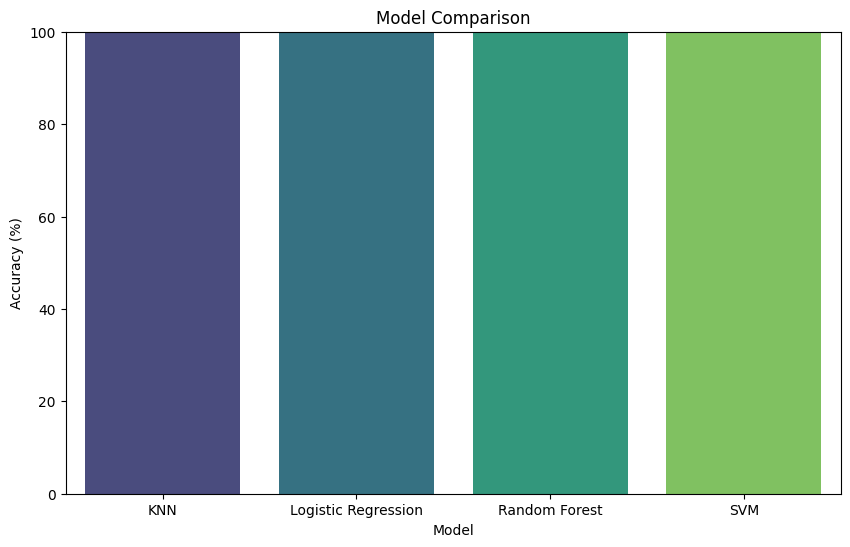

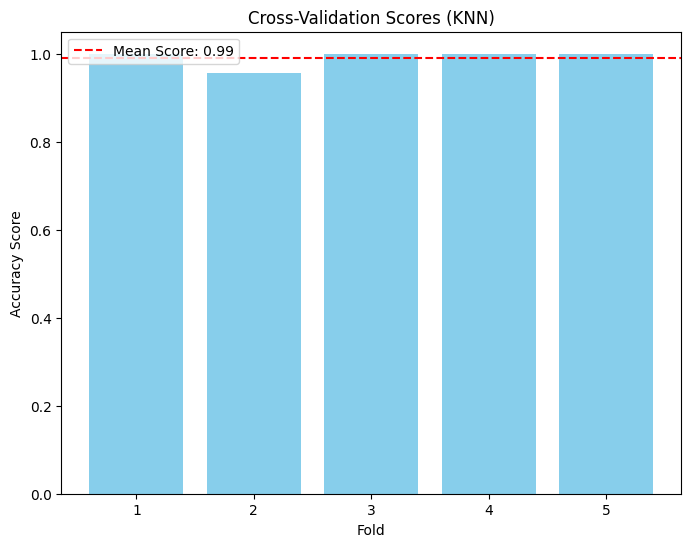

Cross-Validation Scores (KNN): [1.         0.95652174 1.         1.         1.        ]
Mean Cross-Validation Accuracy (KNN): 0.99


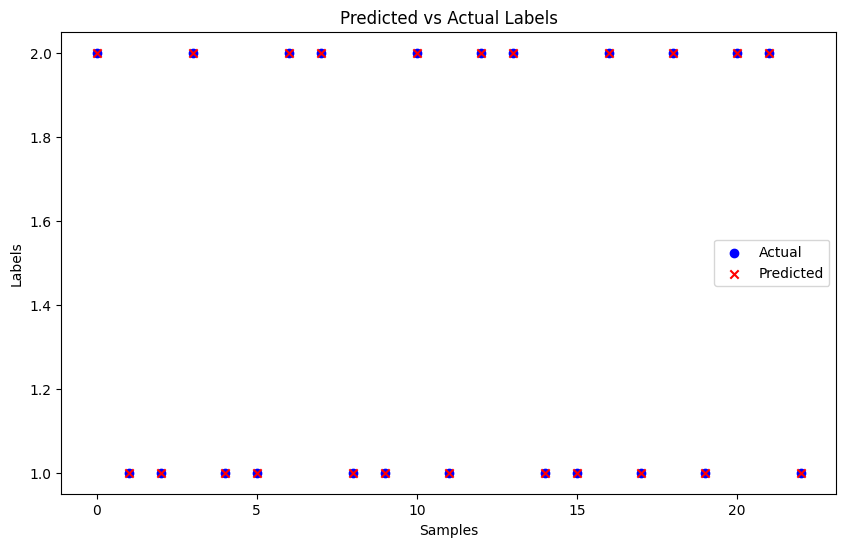

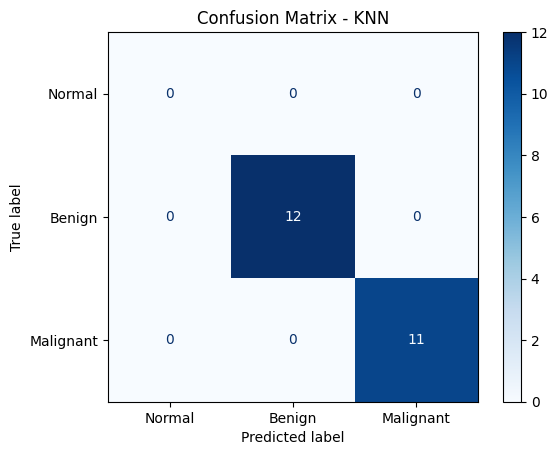

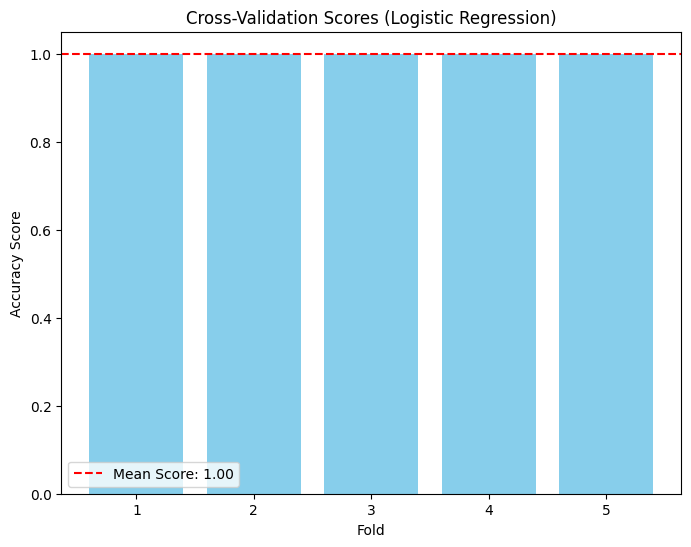

Cross-Validation Scores (Logistic Regression): [1. 1. 1. 1. 1.]
Mean Cross-Validation Accuracy (Logistic Regression): 1.00


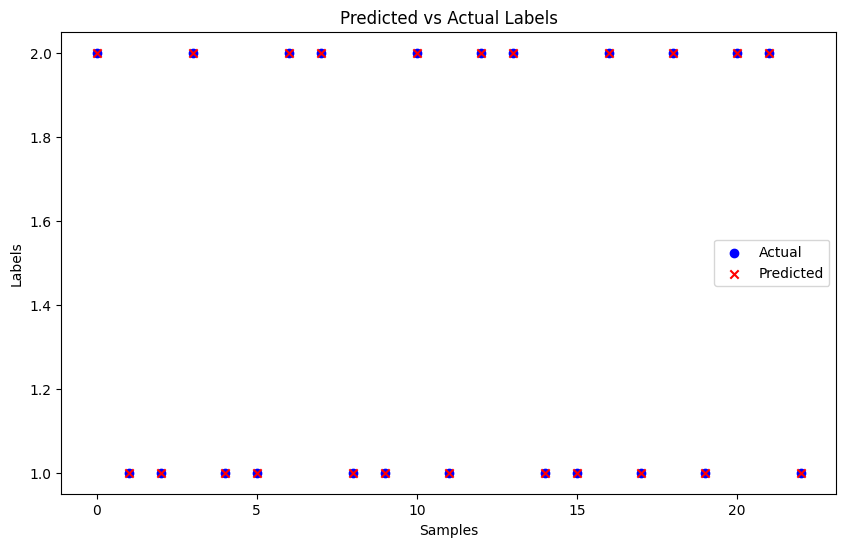

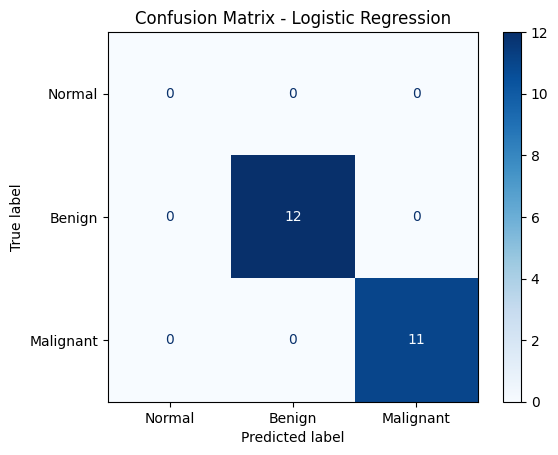

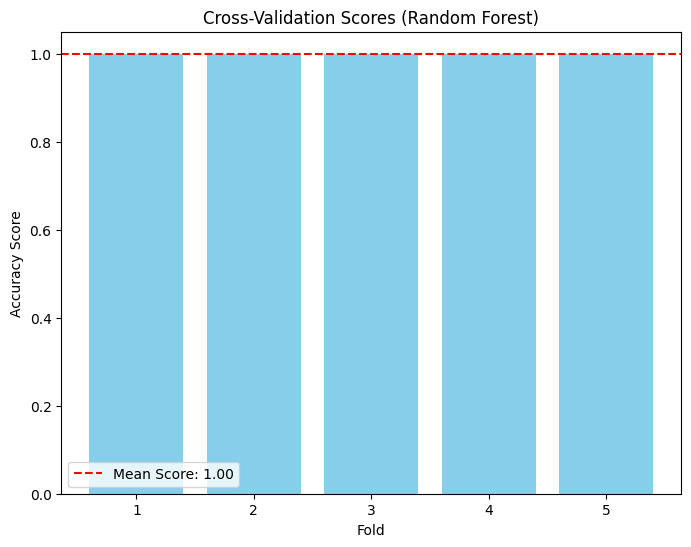

Cross-Validation Scores (Random Forest): [1. 1. 1. 1. 1.]
Mean Cross-Validation Accuracy (Random Forest): 1.00


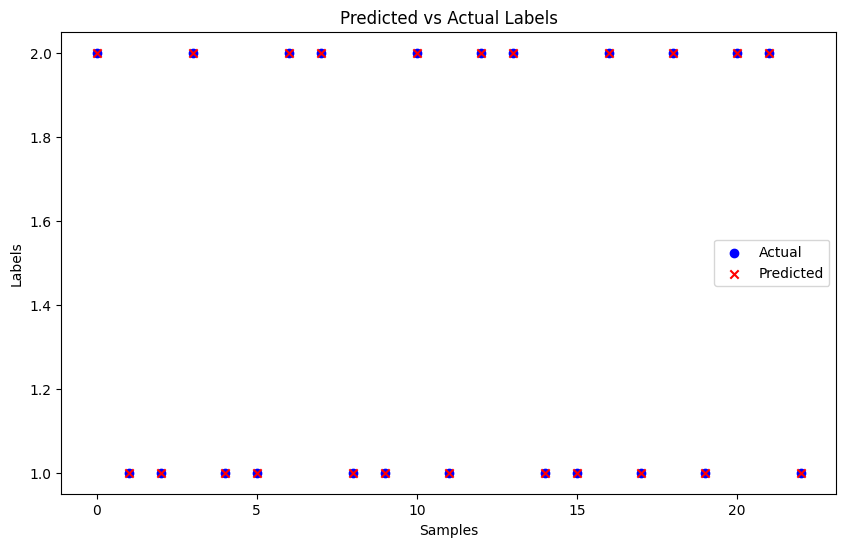

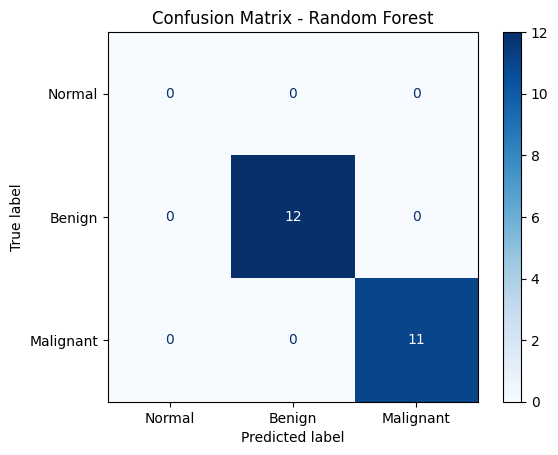

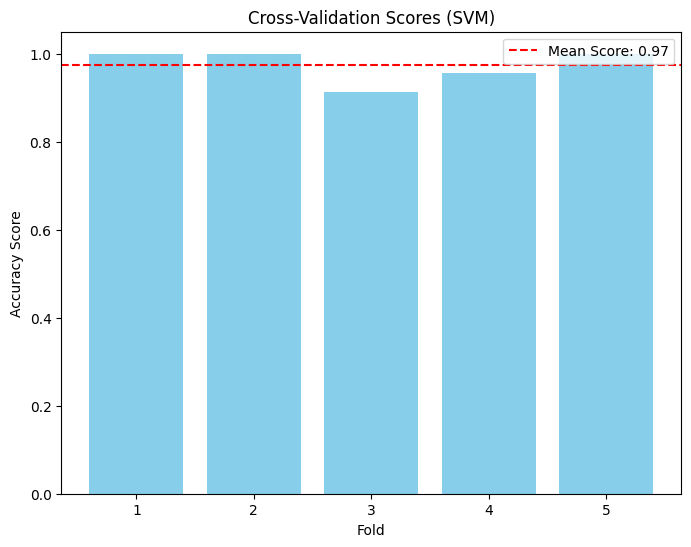

Cross-Validation Scores (SVM): [1.         1.         0.91304348 0.95652174 1.        ]
Mean Cross-Validation Accuracy (SVM): 0.97


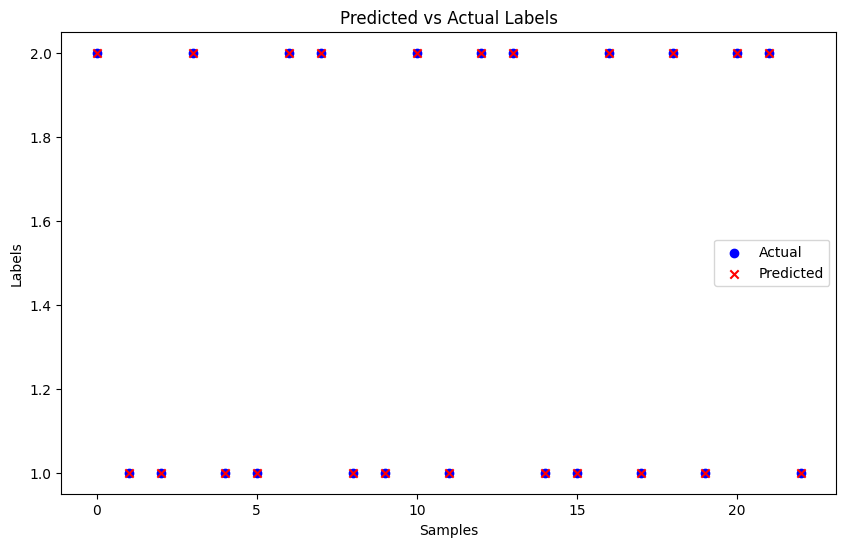

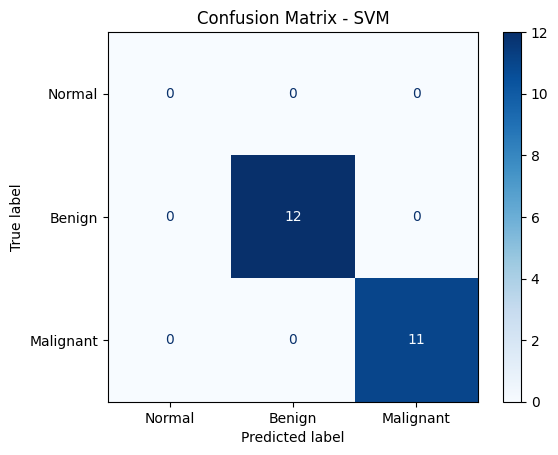

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the datasets
annotations_path = '/content/drive/My Drive/breast_cancer_annotations/breast_cancer_annotations.csv'
benign_path = '/content/drive/My Drive/variance_data_train/benign_features.csv'
malignant_path = '/content/drive/My Drive/variance_data_train/malignant_features.csv'
normal_path = '/content/drive/My Drive/variance_data_train/normal_features.csv'

annotations = pd.read_csv(annotations_path)
benign_features = pd.read_csv(benign_path)
malignant_features = pd.read_csv(malignant_path)



# Step 2: Combine benign and malignant features into one dataset
benign_features['Label'] = 1  # Benign
malignant_features['Label'] = 2  # Malignant
features = pd.concat([benign_features, malignant_features], ignore_index=True)

# Step 3: Merge annotations with features based on a common key (if applicable)
# Assuming 'Image_ID' exists in both datasets
if 'Image_ID' in annotations.columns and 'Image_ID' in features.columns:
    data = pd.merge(features, annotations, on='Image_ID')
else:
    data = features.copy()  # If no matching key, just use the features data

# Step 4: One-hot encode categorical columns (e.g., Density, Lesion_Type)
if 'Density' in data.columns or 'Lesion_Type' in data.columns:
    data = pd.get_dummies(data, columns=['Density', 'Lesion_Type'], drop_first=True)

# Drop 'Image_ID' if it exists (not useful for training)
if 'Image_ID' in data.columns:
    data = data.drop(columns=['Image_ID'])

# Step 5: Extract features and labels
X = data.drop(columns=['Label']).values  # Features
y = data['Label'].values  # Labels: 0 = Normal, 1 = Benign, 2 = Malignant

# Drop 'Image_ID' if it exists (not useful for training)
if 'Image_ID' in data.columns:
    data = data.drop(columns=['Image_ID'])

# Check for non-numeric columns and encode them if necessary
non_numeric_cols = data.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns: {non_numeric_cols}")
    data = pd.get_dummies(data, columns=non_numeric_cols, drop_first=True)

# Extract features and labels
X = data.drop(columns=['Label']).values  # Features
y = data['Label'].values  # Labels: 0 = Normal, 1 = Benign, 2 = Malignant

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Function to train and evaluate models
def evaluate_model(model, param_grid, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"\n--- {model_name} ---")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    return best_model

# Step 7: Train and evaluate models
# KNN
knn_params = {'n_neighbors': range(1, 11)}
best_knn = evaluate_model(KNeighborsClassifier(), knn_params, "KNN")

# Logistic Regression
log_reg_params = {'C': [0.1, 1, 10, 100]}
best_log_reg = evaluate_model(LogisticRegression(max_iter=1000), log_reg_params, "Logistic Regression")

# Random Forest
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
best_rf = evaluate_model(RandomForestClassifier(), rf_params, "Random Forest")

# SVM
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
best_svm = evaluate_model(SVC(), svm_params, "SVM")

# Step 8: Visualize model comparison
models = ['KNN', 'Logistic Regression', 'Random Forest', 'SVM']
accuracies = [
    accuracy_score(y_test, best_knn.predict(X_test)) * 100,
    accuracy_score(y_test, best_log_reg.predict(X_test)) * 100,
    accuracy_score(y_test, best_rf.predict(X_test)) * 100,
    accuracy_score(y_test, best_svm.predict(X_test)) * 100,
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Comparison")
plt.ylim(0, 100)
plt.show()

# Perform 5-Fold Cross-Validation for KNN
knn = KNeighborsClassifier(n_neighbors=3)  # Use best parameters found earlier
cv_scores_knn = cross_val_score(knn, X_scaled, y, cv=5)

# Visualize Cross-Validation Scores
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cv_scores_knn) + 1), cv_scores_knn, color='skyblue')
plt.xlabel("Fold")
plt.ylabel("Accuracy Score")
plt.title("Cross-Validation Scores (KNN)")
plt.axhline(y=cv_scores_knn.mean(), color='r', linestyle='--', label=f'Mean Score: {cv_scores_knn.mean():.2f}')
plt.legend()
plt.show()

print(f"Cross-Validation Scores (KNN): {cv_scores_knn}")
print(f"Mean Cross-Validation Accuracy (KNN): {cv_scores_knn.mean():.2f}")

# Train KNN model and predict
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Visualize Predicted vs. Actual Labels
visualize_predicted_vs_actual(y_test, y_pred_knn)

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[0, 1, 2])
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Normal', 'Benign', 'Malignant'])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN")
plt.show()

# Perform 5-Fold Cross-Validation for Logistic Regression
log_reg = LogisticRegression(max_iter=1000, C=1)  # Use best parameters found earlier
cv_scores_log_reg = cross_val_score(log_reg, X_scaled, y, cv=5)

# Visualize Cross-Validation Scores
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cv_scores_log_reg) + 1), cv_scores_log_reg, color='skyblue')
plt.xlabel("Fold")
plt.ylabel("Accuracy Score")
plt.title("Cross-Validation Scores (Logistic Regression)")
plt.axhline(y=cv_scores_log_reg.mean(), color='r', linestyle='--', label=f'Mean Score: {cv_scores_log_reg.mean():.2f}')
plt.legend()
plt.show()

print(f"Cross-Validation Scores (Logistic Regression): {cv_scores_log_reg}")
print(f"Mean Cross-Validation Accuracy (Logistic Regression): {cv_scores_log_reg.mean():.2f}")
# Train Logistic Regression model and predict
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# Visualize Predicted vs. Actual Labels
visualize_predicted_vs_actual(y_test, y_pred_log_reg)

# Confusion Matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg, labels=[0, 1, 2])
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=['Normal', 'Benign', 'Malignant'])
disp_log_reg.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Perform 5-Fold Cross-Validation for Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=None)  # Use best parameters found earlier
cv_scores_rf = cross_val_score(rf, X_scaled, y, cv=5)

# Visualize Cross-Validation Scores
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cv_scores_rf) + 1), cv_scores_rf, color='skyblue')
plt.xlabel("Fold")
plt.ylabel("Accuracy Score")
plt.title("Cross-Validation Scores (Random Forest)")
plt.axhline(y=cv_scores_rf.mean(), color='r', linestyle='--', label=f'Mean Score: {cv_scores_rf.mean():.2f}')
plt.legend()
plt.show()

print(f"Cross-Validation Scores (Random Forest): {cv_scores_rf}")
print(f"Mean Cross-Validation Accuracy (Random Forest): {cv_scores_rf.mean():.2f}")
# Train Random Forest model and predict
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Visualize Predicted vs. Actual Labels
visualize_predicted_vs_actual(y_test, y_pred_rf)

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1, 2])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Normal', 'Benign', 'Malignant'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Perform 5-Fold Cross-Validation for SVM
svm = SVC(C=1, kernel='linear', gamma='scale')  # Use best parameters found earlier
cv_scores_svm = cross_val_score(svm, X_scaled, y, cv=5)

# Visualize Cross-Validation Scores
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cv_scores_svm) + 1), cv_scores_svm, color='skyblue')
plt.xlabel("Fold")
plt.ylabel("Accuracy Score")
plt.title("Cross-Validation Scores (SVM)")
plt.axhline(y=cv_scores_svm.mean(), color='r', linestyle='--', label=f'Mean Score: {cv_scores_svm.mean():.2f}')
plt.legend()
plt.show()

print(f"Cross-Validation Scores (SVM): {cv_scores_svm}")
print(f"Mean Cross-Validation Accuracy (SVM): {cv_scores_svm.mean():.2f}")
# Train SVM model and predict
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Visualize Predicted vs. Actual Labels
visualize_predicted_vs_actual(y_test, y_pred_svm)

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=[0, 1, 2])
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Normal', 'Benign', 'Malignant'])
disp_svm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # Include cross_val_score here
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the datasets
annotations_path = '/content/drive/My Drive/breast_cancer_annotations/breast_cancer_annotations.csv'
benign_path = '/content/drive/My Drive/variance_data_train/benign_features_oversampled.csv'
malignant_path = '/content/drive/My Drive/variance_data_train/malignant_features_oversampled.csv'
normal_path = '/content/drive/My Drive/variance_data_train/normal_features.csv'

annotations = pd.read_csv(annotations_path)
benign_features_oversampled = pd.read_csv(benign_path)
malignant_features_oversampled = pd.read_csv(malignant_path)
normal_features = pd.read_csv(normal_path)

# Step 2: Assign labels to each dataset
benign_features['Label'] = 1  # Benign
malignant_features['Label'] = 2  # Malignant
normal_features['Label'] = 0  # Normal

# Combine all features into one dataset
features = pd.concat([benign_features, malignant_features, normal_features], ignore_index=True)

# Step 3: Merge annotations with features based on 'Image_ID' (if applicable)
if 'Image_ID' in annotations.columns and 'Image_ID' in features.columns:
    data = pd.merge(features, annotations, on='Image_ID', how='left')
else:
    data = features.copy()

# Step 4: Handle non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Dropping non-numeric columns: {non_numeric_cols}")
    data = data.drop(columns=non_numeric_cols)

# One-hot encode categorical columns (e.g., Density, Lesion_Type) if they exist
if 'Density' in data.columns or 'Lesion_Type' in data.columns:
    data = pd.get_dummies(data, columns=['Density', 'Lesion_Type'], drop_first=True)

# Drop 'Image_ID' if it exists (not useful for training)
if 'Image_ID' in data.columns:
    data = data.drop(columns=['Image_ID'])

# Step 5: Extract features and labels
X = data.drop(columns=['Label']).values  # Features
y = data['Label'].values  # Labels: 0 = Normal, 1 = Benign, 2 = Malignant

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Function to train and evaluate models
def evaluate_model(model, param_grid, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"\n--- {model_name} ---")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    return best_model


# Step 7: Train and evaluate models
# KNN
knn_params = {'n_neighbors': range(1, 11)}
best_knn = evaluate_model(KNeighborsClassifier(), knn_params, "KNN")

# Logistic Regression
log_reg_params = {'C': [0.1, 1, 10, 100]}
best_log_reg = evaluate_model(LogisticRegression(max_iter=1000), log_reg_params, "Logistic Regression")

# Random Forest
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
best_rf = evaluate_model(RandomForestClassifier(), rf_params, "Random Forest")

# SVM
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
best_svm = evaluate_model(SVC(), svm_params, "SVM")

# Dynamic metric extraction
model_names = ['KNN', 'Logistic Regression', 'Random Forest', 'SVM']

# Example metrics (Replace with actual metrics from the classification report)
accuracies = [
    accuracy_score(y_test, best_knn.predict(X_test)) * 100,
    accuracy_score(y_test, best_log_reg.predict(X_test)) * 100,
    accuracy_score(y_test, best_rf.predict(X_test)) * 100,
    accuracy_score(y_test, best_svm.predict(X_test)) * 100,
]

# Precision, recall, F1-score (aggregated across all classes)
precision = [
    classification_report(y_test, best_knn.predict(X_test), output_dict=True)['weighted avg']['precision'],
    classification_report(y_test, best_log_reg.predict(X_test), output_dict=True)['weighted avg']['precision'],
    classification_report(y_test, best_rf.predict(X_test), output_dict=True)['weighted avg']['precision'],
    classification_report(y_test, best_svm.predict(X_test), output_dict=True)['weighted avg']['precision'],
]

recall = [
    classification_report(y_test, best_knn.predict(X_test), output_dict=True)['weighted avg']['recall'],
    classification_report(y_test, best_log_reg.predict(X_test), output_dict=True)['weighted avg']['recall'],
    classification_report(y_test, best_rf.predict(X_test), output_dict=True)['weighted avg']['recall'],
    classification_report(y_test, best_svm.predict(X_test), output_dict=True)['weighted avg']['recall'],
]

f1_scores = [
    classification_report(y_test, best_knn.predict(X_test), output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, best_log_reg.predict(X_test), output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, best_rf.predict(X_test), output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, best_svm.predict(X_test), output_dict=True)['weighted avg']['f1-score'],
]

# 1. Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xlabel("Models")
plt.ylim(0, 100)
plt.show()

# 2. Precision, Recall, F1-Score Comparison
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1_scores]

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, metric in enumerate(metrics):
    sns.barplot(ax=ax[i], x=model_names, y=values[i], palette="coolwarm")
    ax[i].set_title(f"{metric} Comparison")
    ax[i].set_ylabel(metric)
    ax[i].set_xlabel("Models")
    ax[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# 3. Confusion Matrix Visualization for All Models
models_confusion_matrices = {
    "KNN": confusion_matrix(y_test, best_knn.predict(X_test)),
    "Logistic Regression": confusion_matrix(y_test, best_log_reg.predict(X_test)),
    "Random Forest": confusion_matrix(y_test, best_rf.predict(X_test)),
    "SVM": confusion_matrix(y_test, best_svm.predict(X_test)),
}

for model_name, cm in models_confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Normal', 'Benign', 'Malignant'],
                yticklabels=['Normal', 'Benign', 'Malignant'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


Dropping non-numeric columns: Index(['img_id', 'label'], dtype='object')


ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1223, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Error in KNN: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages

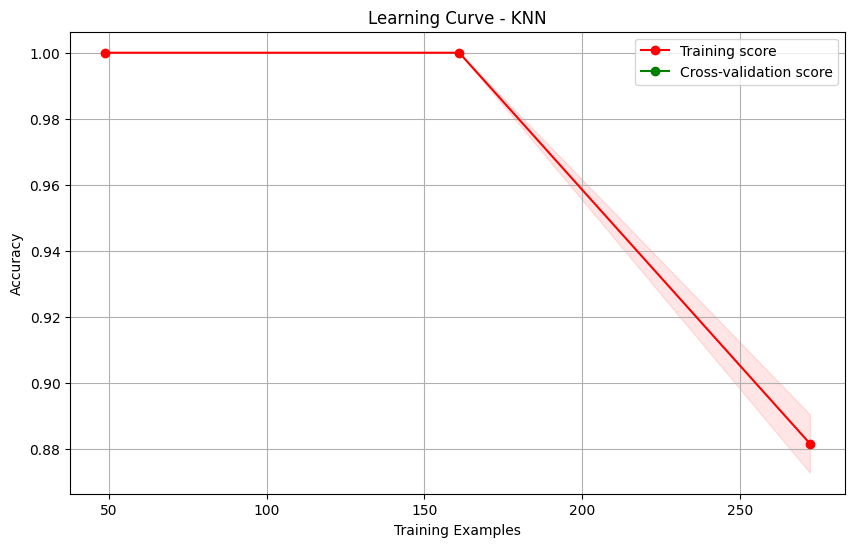

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Error in Logistic Regression: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 cl

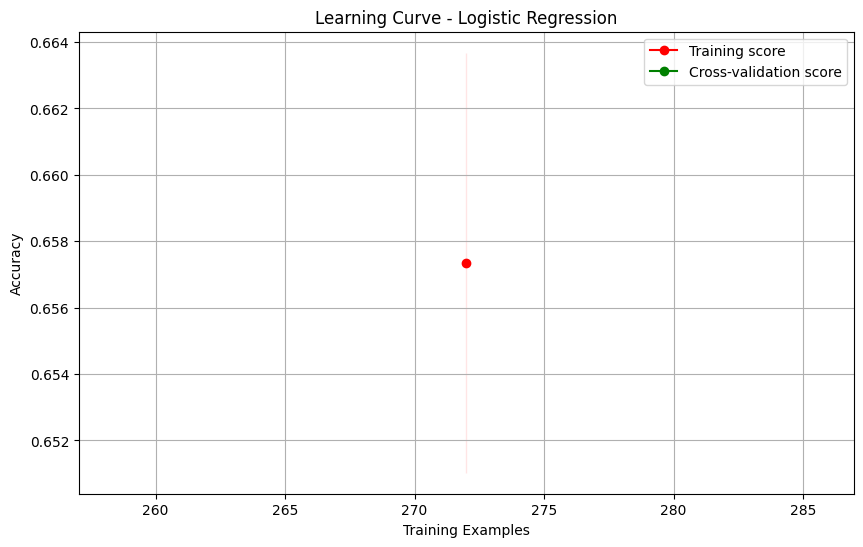

Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- Random Forest ---
Best Params: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 96.00%


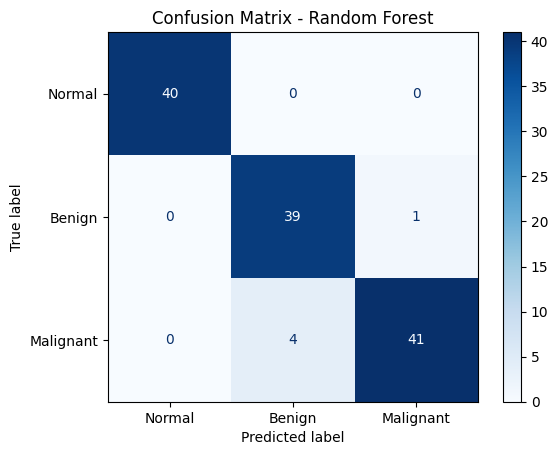

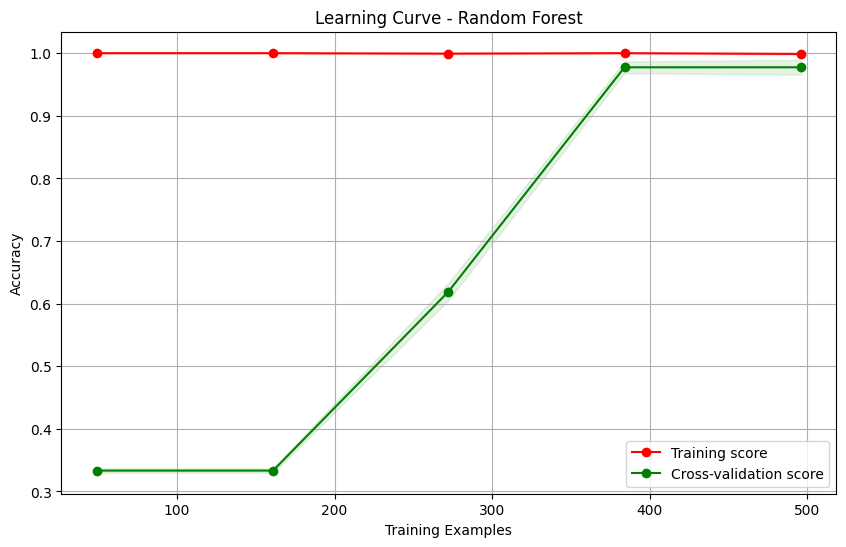

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Error in SVM: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/

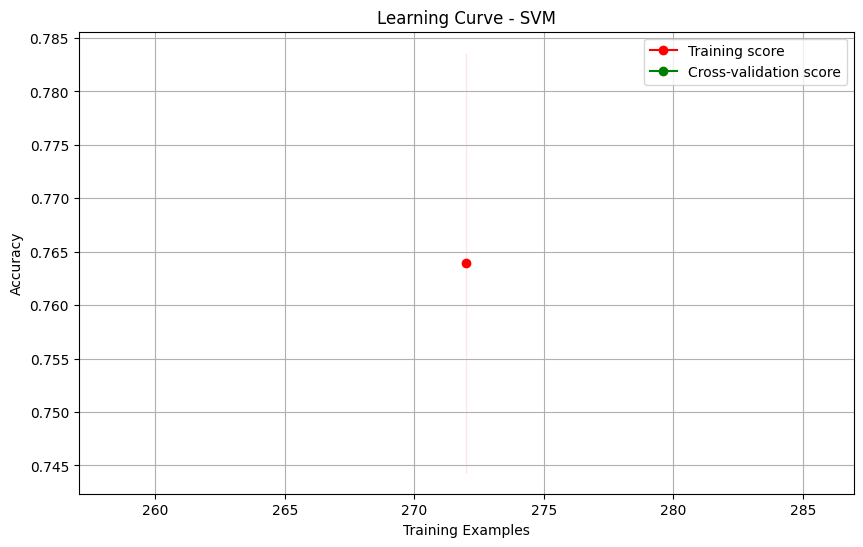

NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')


# Bước 1: Load dữ liệu oversampling và annotation
annotations_path = '/content/drive/My Drive/breast_cancer_annotations/breast_cancer_annotations.csv'
benign_path = '/content/drive/My Drive/variance_data_train/benign_features_oversampled.csv'
malignant_path = '/content/drive/My Drive/variance_data_train/malignant_features_oversampled.csv'
normal_path = '/content/drive/My Drive/variance_data_train/normal_features.csv'

annotations = pd.read_csv(annotations_path)
benign_features_oversampled = pd.read_csv(benign_path)
malignant_features_oversampled = pd.read_csv(malignant_path)
normal_features = pd.read_csv(normal_path)

# Bước 2: Gán nhãn cho từng lớp
benign_features['Label'] = 1  # Benign
malignant_features['Label'] = 2  # Malignant
normal_features['Label'] = 0  # Normal

# Gộp tất cả dữ liệu thành một tập hợp
features = pd.concat([benign_features, malignant_features, normal_features], ignore_index=True)

# Bước 3: Kết hợp dữ liệu oversampling với annotation
if 'Image_ID' in annotations.columns and 'Image_ID' in features.columns:
    data = pd.merge(features, annotations, on='Image_ID', how='left')
else:
    data = features.copy()

# Bước 4: Xử lý dữ liệu
non_numeric_cols = data.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    data = data.drop(columns=non_numeric_cols)

if 'Density' in data.columns or 'Lesion_Type' in data.columns:
    data = pd.get_dummies(data, columns=['Density', 'Lesion_Type'], drop_first=True)

# Bước 5: Chuẩn bị dữ liệu huấn luyện
X = data.drop(columns=['Label']).values  # Features
y = data['Label'].values  # Labels: 0 = Normal, 1 = Benign, 2 = Malignant

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Bước 6: Hàm vẽ Learning Curve
def plot_learning_curve(estimator, title, X, y, cv=5, scoring="accuracy"):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel(scoring.capitalize())
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Bước 7: Hàm huấn luyện và đánh giá mô hình
def evaluate_model_with_metrics(model, param_grid, model_name):
    try:
        grid_search = GridSearchCV(model, param_grid, cv=5, error_score='raise', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        print(f"\n--- {model_name} ---")
        print(f"Best Params: {grid_search.best_params_}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

        cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Benign', 'Malignant'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()
        return best_model
    except ValueError as e:
        print(f"Error in {model_name}: {e}")
        return model


# KNN
knn_params = {'n_neighbors': range(1, min(11, len(X_train)))}
best_knn = evaluate_model_with_metrics(KNeighborsClassifier(), knn_params, "KNN")
if best_knn is not None:
    plot_learning_curve(best_knn, "Learning Curve - KNN", X_scaled, y)

# Logistic Regression
log_reg_params = {'C': [0.1, 1, 10, 100]}
best_log_reg = evaluate_model_with_metrics(LogisticRegression(max_iter=1000), log_reg_params, "Logistic Regression")
if best_log_reg:
    plot_learning_curve(best_log_reg, "Learning Curve - Logistic Regression", X_scaled, y)

# Random Forest
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
best_rf = evaluate_model_with_metrics(RandomForestClassifier(), rf_params, "Random Forest")
if best_rf:
    plot_learning_curve(best_rf, "Learning Curve - Random Forest", X_scaled, y)

# SVM
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
best_svm = evaluate_model_with_metrics(SVC(), svm_params, "SVM")
if best_svm:
    plot_learning_curve(best_svm, "Learning Curve - SVM", X_scaled, y)

models = []
accuracies = []

if best_knn is not None:
    models.append("KNN")
    accuracies.append(accuracy_score(y_test, best_knn.predict(X_test)) * 100)

if best_log_reg is not None:
    models.append("Logistic Regression")
    accuracies.append(accuracy_score(y_test, best_log_reg.predict(X_test)) * 100)

if best_rf is not None:
    models.append("Random Forest")
    accuracies.append(accuracy_score(y_test, best_rf.predict(X_test)) * 100)

if best_svm is not None:
    models.append("SVM")
    accuracies.append(accuracy_score(y_test, best_svm.predict(X_test)) * 100)

# So sánh hiệu suất giữa các mô hình
models = ['KNN', 'Logistic Regression', 'Random Forest', 'SVM']
accuracies = [
    accuracy_score(y_test, best_knn.predict(X_test)) * 100,
    accuracy_score(y_test, best_log_reg.predict(X_test)) * 100,
    accuracy_score(y_test, best_rf.predict(X_test)) * 100,
    accuracy_score(y_test, best_svm.predict(X_test)) * 100,
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Comparison")
plt.ylim(0, 100)
plt.show()


<ipython-input-6-42d81a6f06a0>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=class_distribution, palette="viridis")


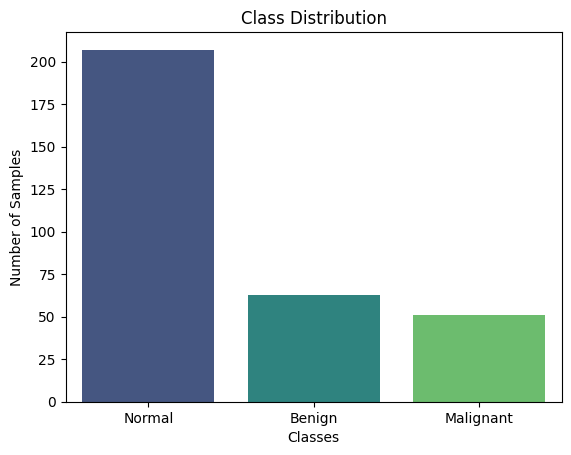

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trực quan hóa phân bố dữ liệu
class_distribution = pd.DataFrame({'Label': ['Normal', 'Benign', 'Malignant'],
                                   'Count': [207, 63, 51]})
sns.barplot(x='Label', y='Count', data=class_distribution, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_psd(image):
    # Apply FFT to the image
    f = np.fft.fft2(image)
    # Shift the zero frequency component to the center
    fshift = np.fft.fftshift(f)
    # Compute the Power Spectral Density (PSD)
    psd = np.abs(fshift) ** 2
    return psd

# Paths to the images
image_path1 = ''
image_path2 = ''

try:
    # Load the first image
    img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    if img1 is None:
        raise ValueError(f"Image not found or unable to load: {image_path1}")

    # Load the second image
    img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
    if img2 is None:
        raise ValueError(f"Image not found or unable to load: {image_path2}")

    # Compute the PSD for the first image
    psd1 = compute_psd(img1)
    # Compute the logarithm of the PSD for better visualization
    psd1_log = 10 * np.log10(psd1 + 1)

    # Compute the PSD for the second image
    psd2 = compute_psd(img2)
    # Compute the logarithm of the PSD for better visualization
    psd2_log = 10 * np.log10(psd2 + 1)

    # Display the original images and their PSDs
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title('Original Image (mdb001.pgm)')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(psd1_log, cmap='gray')
    plt.title('Power Spectral Density (mdb001.pgm)')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(img2, cmap='gray')
    plt.title('Original Image (mdb002.pgm)')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(psd2_log, cmap='gray')
    plt.title('Power Spectral Density (mdb002.pgm)')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(e)

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Bước 1: Load dữ liệu từ file CSV
benign_path = '/content/drive/My Drive/variance_data_train/benign_features_extended.csv'
malignant_path = '/content/drive/My Drive/variance_data_train/malignant_features_extended.csv'
normal_path = '/content/drive/My Drive/variance_data_train/normal_features.csv'

benign_features = pd.read_csv(benign_path)
malignant_features = pd.read_csv(malignant_path)
normal_features = pd.read_csv(normal_path)

# Kiểm tra số lượng mẫu ban đầu
print(f"Original Benign Samples: {len(benign_features)}")
print(f"Original Malignant Samples: {len(malignant_features)}")
print(f"Original Normal Samples: {len(normal_features)}")

# Bước 2: Oversample dữ liệu của lớp Benign và Malignant
# Số mẫu mục tiêu (cân bằng với lớp Normal)
target_samples = len(normal_features)

benign_oversampled = resample(
    benign_features,
    replace=True,  # Oversampling (cho phép nhân bản mẫu)
    n_samples=target_samples,  # Số lượng mẫu mục tiêu
    random_state=42  # Đảm bảo kết quả tái hiện được
)

malignant_oversampled = resample(
    malignant_features,
    replace=True,  # Oversampling
    n_samples=target_samples,  # Số lượng mẫu mục tiêu
    random_state=42
)

# Kiểm tra số lượng mẫu sau khi oversample
print(f"Oversampled Benign Samples: {len(benign_oversampled)}")
print(f"Oversampled Malignant Samples: {len(malignant_oversampled)}")

# Bước 3: Lưu lại dữ liệu oversample vào file CSV mới
oversampled_benign_path = '/content/drive/My Drive/variance_data_train/benign_features_oversampled.csv'
oversampled_malignant_path = '/content/drive/My Drive/variance_data_train/malignant_features_oversampled.csv'

benign_oversampled.to_csv(oversampled_benign_path, index=False)
malignant_oversampled.to_csv(oversampled_malignant_path, index=False)

print(f"Oversampled Benign saved to: {oversampled_benign_path}")
print(f"Oversampled Malignant saved to: {oversampled_malignant_path}")


Original Benign Samples: 63
Original Malignant Samples: 51
Original Normal Samples: 207
Oversampled Benign Samples: 207
Oversampled Malignant Samples: 207
Oversampled Benign saved to: /content/drive/My Drive/variance_data_train/benign_features_oversampled.csv
Oversampled Malignant saved to: /content/drive/My Drive/variance_data_train/malignant_features_oversampled.csv


In [ ]:
import pandas as pd

# Đọc dữ liệu từ các tệp CSV
benign_path = '/content/drive/My Drive/Oversampling Data/benign_features_oversampled.csv'
malignant_path = '/content/drive/My Drive/variance_data_train/malignant_features_oversampled.csv'
normal_path = '/content/drive/My Drive/variance_data_train/normal_features.csv'

# Đọc từng tệp vào DataFrame
benign_data = pd.read_csv(benign_path)
malignant_data = pd.read_csv(malignant_path)
normal_data = pd.read_csv(normal_path)

# Gán nhãn cho từng lớp
benign_data['label'] = 1  # Benign
malignant_data['label'] = 2  # Malignant
normal_data['label'] = 0  # Normal

# Gộp dữ liệu
data = pd.concat([benign_data, malignant_data, normal_data], ignore_index=True)

# Kiểm tra dữ liệu
print("Dữ liệu gộp:")
print(data.shape)  # Số hàng và cột
print(data['label'].value_counts())  # Kiểm tra số lượng mẫu mỗi lớp

# Lưu dữ liệu gộp
output_path = '/content/drive/My Drive/final_data/final_data.csv'  # Đường dẫn lưu tệp
data.to_csv(output_path, index=False)
print(f"Tệp dữ liệu đã được lưu tại: {output_path}")


Dữ liệu gộp:
(621, 10)
label
1    207
2    207
0    207
Name: count, dtype: int64
Tệp dữ liệu đã được lưu tại: /content/drive/My Drive/final_data/final_data.csv


In [ ]:
from sklearn.preprocessing import StandardScaler

# Loại bỏ cột chuỗi (nếu có) và giữ lại các đặc trưng số
if 'img_id' in data.columns:  # Kiểm tra nếu cột 'img_id' tồn tại
    data = data.drop(columns=['img_id'])

# Tách cột đặc trưng (features) và nhãn (label)
features = data.drop(columns=['label'])  # Loại bỏ cột nhãn
labels = data['label']  # Tách nhãn

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Chuyển dữ liệu đã chuẩn hóa thành DataFrame
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Gộp lại với nhãn
data_scaled = pd.concat([features_scaled_df, labels.reset_index(drop=True)], axis=1)

# Kiểm tra dữ liệu đã chuẩn hóa
print("Dữ liệu sau khi chuẩn hóa:")
print(data_scaled.head())

# Lưu dữ liệu đã chuẩn hóa
output_scaled_path = '/content/drive/My Drive/final_data/final_data_scaled.csv'
data_scaled.to_csv(output_scaled_path, index=False)
print(f"Dữ liệu đã chuẩn hóa được lưu tại: {output_scaled_path}")


Dữ liệu sau khi chuẩn hóa:
   variance_equalized  variance_filtered  variance_psd  variance_local  \
0            0.779571          -0.247019     -0.385092        0.321878   
1           -0.807890          -0.664754     -0.509475       -0.502161   
2            1.296220           1.543559      1.554856        2.007870   
3            0.916856          -0.373316     -0.414717        0.938713   
4            0.868375           0.462484     -0.306201        0.236632   

   variance_frequency  variance_noise  variance_horizontal  variance_vertical  \
0            0.511967        0.297569            -0.143333           1.266087   
1           -1.073985       -1.123357            -0.604517          -0.096510   
2            3.566724        1.525118             2.557893          -0.749902   
3           -0.663818        0.807745            -0.652229           0.555664   
4            0.417582        0.595531             0.425066           1.522986   

   label  
0      1  
1      1  
2      1

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Đọc dữ liệu từ các tệp CSV
benign_path = '/content/drive/My Drive/Oversampling Data/benign_features_oversampled.csv'
malignant_path = '/content/drive/My Drive/variance_data_train/malignant_features_oversampled.csv'
#normal_path = '/content/drive/My Drive/variance_data_train/normal_features.csv'

benign_data = pd.read_csv(benign_path)
malignant_data = pd.read_csv(malignant_path)
normal_data = pd.read_csv(normal_path)

# Gán nhãn cho từng lớp
benign_data['label'] = 1  # Benign
malignant_data['label'] = 2  # Malignant
normal_data['label'] = 0  # Normal

# Gộp dữ liệu
data = pd.concat([benign_data, malignant_data], ignore_index=True)

# Loại bỏ cột không phải số (nếu có)
if 'img_id' in data.columns:
    data = data.drop(columns=['img_id'])

# Tách đặc trưng (features) và nhãn (label)
features = data.drop(columns=['label'])
labels = data['label']

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Chuyển thành DataFrame và gộp lại với nhãn
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
data_scaled = pd.concat([features_scaled_df, labels.reset_index(drop=True)], axis=1)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X = data_scaled.drop(columns=['label'])
y = data_scaled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lưu tập huấn luyện
train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
train_path = '/content/drive/My Drive/final_data/train_data.csv'
train_data.to_csv(train_path, index=False)
print(f"Tập huấn luyện đã được lưu tại: {train_path}")

# Lưu tập kiểm tra
test_data = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)
test_path = '/content/drive/My Drive/final_data/test_data.csv'
test_data.to_csv(test_path, index=False)
print(f"Tập kiểm tra đã được lưu tại: {test_path}")


Tập huấn luyện đã được lưu tại: /content/drive/My Drive/final_data/train_data.csv
Tập kiểm tra đã được lưu tại: /content/drive/My Drive/final_data/test_data.csv
